In [2]:
import pandas as pd
import re
import numpy as np
import textstat
import random
from textblob import TextBlob
import matplotlib.pyplot as plt
from ethnicolr import pred_wiki_name
from flair.data import Sentence
from flair.models import SequenceTagger
import pyethnicity
# Temporarily adjust option to display up to 500 columns 
pd.set_option('display.max_info_columns', 500)

# Import the filtered file

In [2]:
df=pd.read_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_filtered_usd_v4.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

# Generate Education related columns

## Generate columns named Education_Context(the Educaitonal Context form Biography)  ,High_Educated_Bio(a boolean indicator (True/False) of whether the biography contains any education-related context),Eductional_level( the level of the education received,the higher ,the smaller

### PhD and Ph.D. Pattern Matching  ，可以match但设定了re.ignorecase会导致r'\b[A-Z]\.[A-Z]\.[A-Z]\.\b',  这里完全不能match capital letter，因为不管大小写都会match 去掉

In [4]:
# Define the full and expanded list of education-related keywords
education_keywords = [
  # Specific terms
    r'\bgrad\b', 'graduate', 'degree', 'alumnus', 'alumna', 'graduand', r'\diploma\b',
    'educated', 'educating', 'graduation', 'graduating',
    # Institutions
    'academy', 'institute', 'university', 'college', r'\bUniv\b', 
    # Degree abbreviations with word boundaries
    'bachelor', 'bachelor\'s', 'undergraduate' , r'\bundergra\b', r'\bundergrad\b',
    r'\bba\b', r'\bbsc\b', r'\bbba\b', r'\bbbs\b', r'\bb\.a\.\b', r'\bb\.?S\.?\b', r'\bbfa\b', r'\bbacc\b', r'\bBASc\b', r'\bBOptom\b',
    r'\bBDS\b', r'\bBDes\b', r'\bBD\b', r'\bBScEcon\b',  r'\bBEng\b', r'\bBFin\b', r'\bBHSc\b', r'\bLLB\b', r'\bBMedSci\b',
    r'\bBM\b', r'\bBMBS\b', r'\bBMus\b', r'\bBNurs\b', r'\bBSc\b', r'\bBSocSc\b', r'\bBSW\b', r'\bBTech\b', r'\bBPharm\b', r'\bBLitt\b',
    r'\bBCL\b', r'\bLLM\b',   r'\bOD\b', r'\bDVM\b', r'\bPharmD\b',
    
    r'\bmaster\b', r'\bmasters\b', 'mphil', 'postgraduate', r'\bms\b', r'\bmba\b', r'\bm\.b\.a\.\b', r'\bma\b', r'\bm\.a\.\b', r'\bm\.s\.\b',
    r'\bMSc\b', r'\bMEng\b', r'\bMEd\b', r'\bMFA\b', r'\bMBA\b', r'\bMPhil\b', r'\bLLM\b', r'\bMPA\b', r'\bMPP\b', r'\bMSW\b',
    r'\bMTech\b', r'\bMPharm\b', r'\bMRes\b', r'\bMLitt\b',
    r'\bPh\.?d\b', r'\bdr\b', r'\bdoctor\b', 'doctoral', 'doctorate', 'postdoc', 'postdoctoral', 'phd', 'dphil','Post Doc',
    # Other educational terms
    'summa cum laude', 'magna cum laude', 'cum laude', 'dean\'s list','dissertation','thesis'
]

# Adjusting the function to identify and return the specific matching keywords
def identify_matching_keywords(sentence, keywords):
    matches = []
    # Check if sentence is a string
    if isinstance(sentence, str):
        for keyword in keywords:
            if re.search(keyword, sentence, re.IGNORECASE):
                matches.append(keyword)
        # Expanded pattern to match various phrases indicating education at an institution
       # Updated pattern
        education_pattern = r'\b(student|graduated|graduate|graduating|go to|went to|earned a degree|earning a degree|received a degree|holds a degree|receive a degree|studying|studied|enrolled|enrolling|alumni|education|education background|academic background)\b\s+(in|at|from)\b.*?(\b[A-Z][\w\s]*(University|College|Institute|School|Academy|Tech)\b)'



        education_matches = re.findall(education_pattern, sentence, re.IGNORECASE)
        matches.extend([match[2] for match in education_matches])
    return matches

df['Education_Context'] = df['Biography'].apply(lambda x: identify_matching_keywords(x, education_keywords))
df['High_Educated_Bio'] = df['Education_Context'].apply(lambda x: bool(x))



In [5]:
def extract_education_level(keywords_list):
    # Define categories for different educational levels
    doctorate_keywords = ['phd', 'doctoral', 'doctorate', 'postdoc', 'postdoctoral', r'\bPh\.?d\b', r'\bDr\b', r'\bdoctor\b', 'Post Doc']
    graduate_keywords = [r'\bmaster\b', r'\bmasters\b', 'mphil', 'postgraduate', r'\bms\b', r'\bmba\b', r'\bm\.b\.a\.\b', r'\bma\b', r'\bm\.a\.\b', r'\bm\.s\.\b',
                         r'\bMSc\b', r'\bMEng\b', r'\bMEd\b', r'\bMFA\b', r'\bMBA\b', r'\bMPhil\b', r'\bLLM\b', r'\bMPA\b', r'\bMPP\b', r'\bMSW\b',
                         r'\bMTech\b', r'\bMPharm\b', r'\bMRes\b', r'\bMLitt\b']
    bachelors_keywords = [
        r'\bgrad\b', 'graduate', 'degree', 'alumnus', 'alumna', 'graduand', r'\diploma\b',
        'educated', 'educating', 'graduated', 'graduation', 'graduating',
        'academy', 'institute', 'university', 'college', r'\bUniv\b',
        'bachelor', 'bachelor\'s', 'undergraduate', r'\bundergra\b', r'\bundergrad\b',
        r'\bba\b', r'\bbsc\b', r'\bbba\b', r'\bbbs\b', r'\bb\.a\.\b', r'\bb\.?S\.?\b', r'\bbfa\b', r'\bbacc\b', r'\bBASc\b', r'\bBOptom\b',
        r'\bBDS\b', r'\bBDes\b', r'\bBD\b', r'\bBScEcon\b', r'\bBEd\b', r'\bBEng\b', r'\bBFin\b', r'\bBHSc\b', r'\bLLB\b', r'\bBMedSci\b',
        r'\bBM\b', r'\bBMBS\b', r'\bBMus\b', r'\bBNurs\b', r'\bBSc\b', r'\bBSocSc\b', r'\bBSW\b', r'\bBTech\b', r'\bBPharm\b', r'\bBLitt\b',
        r'\bBCL\b', r'\bLLM\b', r'\bMD\b', r'\bDC\b', r'\bOD\b', r'\bDVM\b', r'\bPharmD\b',
        'summa cum laude', 'magna cum laude', 'cum laude', 'dean\'s list', 'dissertation', 'thesis'
    ]

    # Check for matches starting from the highest level
    if any(keyword in keywords_list for keyword in doctorate_keywords):
        return 'Doctorate'  # Doctorate level
    elif any(keyword in keywords_list for keyword in graduate_keywords):
        return 'Graduate'  # Graduate level
    elif any(keyword in keywords_list for keyword in bachelors_keywords):
        return 'Bachelors'  # Bachelor's level
    else:
        return 'Below Bachelors'  # High school level or lower / no match

# Applying the function to the DataFrame
df['Education_Level'] = df['Education_Context'].apply(extract_education_level)


In [6]:
df['Education_Level'].unique()

array(['Below Bachelors', 'Bachelors', 'Graduate', 'Doctorate'],
      dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

## Testing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

# Generate  Basic columns

##  Concatenate 'ProjectName', 'ProjectDescription', and 'Story' into a new 'Description' column,clean  it and Generated columns named DescriptionLength(Calculating Description Length)  

In [9]:
# Function to clean text by removing punctuation, emojis, and other non-alphanumeric characters
def clean_text(text):
    # Remove emojis and other non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Optionally, remove digits
    # text = re.sub(r'\d+', '', text)
    return text

# Concatenate 'ProjectName', 'ProjectDescription', and 'Story' into a new 'Description' column
df['Description'] = df['ProjectName'].fillna('') + ' ' + df['ProjectDescription'].fillna('') + ' ' + df['Story'].fillna('')


# Generate 'DescriptionLength' column by counting the number of words in the cleaned 'Description'
df['DescriptionLength'] = df['Description'].apply(lambda x: len(clean_text(x).split()))





In [10]:
# Specified columns to present
columns_to_present = ['ProjectID', 'ProjectName', 'ProjectDescription', 'Story', 'Description', 'DescriptionLength']

# Randomly select a row (project) from the DataFrame
random_row = df.sample(n=1).iloc[0]  # .iloc[0] to get Series from one-row DataFrame

# Print details of the randomly selected project for the specified columns
print("Randomly Selected Project Details:")
for col in columns_to_present:
    print(f"{col}: {random_row[col]}")

Randomly Selected Project Details:
ProjectID: 11145
ProjectName: Virtual Reality Animal Dissection Program
ProjectDescription: A virtual reality alternative to animal dissections developed using state of the art programming and tools.
Story: Here are some facts you should know about classroom animal dissections:  


50,000 cats are used in dissections in US schools each year 

Over 12 million animals are killed each year for classroom dissection purposes in the US alone 

Frog dissections in one classroom costs $4,000 over 5 years 

 

Cat dissections in the same classroom will cost about $14,000 



Admittedly, there is valuable biology and anatomy lessons to be learned, but what if it could be done in virtual reality?
By using dissections in virtual reality, schools can save on the expensive annual costs of animal acquisition without causing harm to a single creature. 

VR dissections are the ultimate example of user-friendly science education solutions. Unlike classroom dissections,

## clean  the  Description and generate DescriptionSentiment(Sentiment Analysis) of DescriptionClarity(Readability Score)

In [11]:
# Function to calculate sentiment on cleaned text
def calculate_sentiment(text):
    cleaned_text = clean_text(text)  # Clean the text first
    return TextBlob(cleaned_text).sentiment.polarity  # Then calculate sentiment

# Apply the function to each row in the 'Description' column to create 'DescriptionSentiment'
df['DescriptionSentiment'] = df['Description'].apply(calculate_sentiment)

# Function to calculate Flesch-Kincaid Grade Level on cleaned text
def calculate_fk_grade(text):
    cleaned_text = clean_text(text)  # Clean the text first
    try:
        return textstat.flesch_kincaid_grade(cleaned_text)
    except:
        return None  # Return None or a default value if text is invalid

# Apply the function to each row in the 'Description' column to create 'DescriptionClarity'
df['DescriptionClarity'] = df['Description'].apply(calculate_fk_grade)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

## Generated columns named Supportiveness(ratio of pledged amount to the number of backers)  ,Video_in_description(the total number of videos in the description)

In [13]:
# Calculate 'Supportiveness' as the ratio of pledged amount to the number of backers.
# If the number of backers is zero, set the value to zero to avoid division by zero.

df['Supportiveness'] = np.where(df['Backer'] == 0, 0, df['Pledged'] / df['Backer'])
# Count the total number of videos in the description, combining 'videoCount' and 'youtubeCount'.
df['Video_in_Description']=df['videoCount']+df['youtubeCount']

In [14]:
# Perform logarithmic transformations and maintain NaN values
df['Total pledges'] =np.log1p(df['Pledged'].dropna())
df['Time span'] =np.log1p(df['Days'].dropna())
df['Financing goal'] = np.log1p(df['Goal'].dropna())
df['Log_DescriptionLength'] = np.log1p(df['DescriptionLength'].dropna())


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

In [16]:
# df.to_excel('kickstarter_old.xlsx', index=True)
# df=pd.read_excel('kickstarter_old.xlsx')
# df.head()

## Generated time related columns

In [17]:
# Extract Year, Month, Day for 'StartDate'
df['YearStartDate'] = df['StartDate'].dt.year
df['MonthStartDate'] = df['StartDate'].dt.month
df['DayStartDate'] = df['StartDate'].dt.day

# Extract Year, Month, Day for 'EndDate'
df['YearEndDate'] = df['EndDate'].dt.year
df['MonthEndDate'] = df['EndDate'].dt.month
df['DayEndDate'] = df['EndDate'].dt.day

In [18]:
df[['ProjectID','StartDate', 'YearStartDate', 'MonthStartDate','DayStartDate','EndDate', 'YearEndDate', 'MonthEndDate','DayEndDate']].head()

,ProjectID,StartDate,YearStartDate,MonthStartDate,DayStartDate,EndDate,YearEndDate,MonthEndDate,DayEndDate
0,3,2019-05-07,2019,5,7,2019-06-06,2019,6,6
1,7,2021-04-21,2021,4,21,2021-06-02,2021,6,2
2,8,2015-02-25,2015,2,25,2015-03-27,2015,3,27
3,11,2015-06-30,2015,6,30,2015-07-30,2015,7,30
4,15,2020-08-26,2020,8,26,2020-10-02,2020,10,2


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

# Generated location related columns

In [20]:
df['ProjectLocation'].head(50)

0          New Castle, DE
1          New Castle, DE
2         Minneapolis, MN
3             Phoenix, AZ
4             Bozeman, MT
5       San Francisco, CA
6          Pittsburgh, PA
7              Austin, TX
8                Reno, NV
9             Danvers, MA
10            Newtown, CT
11           New York, NY
12      San Francisco, CA
13        West Mystic, CT
14             Boston, MA
15             Austin, TX
16          San Diego, CA
17           New York, NY
18             Boston, MA
19           Pasadena, CA
20    West Palm Beach, FL
21            Orlando, FL
22              Omaha, NE
23       Willow Grove, PA
24             Ithaca, NY
25        Los Angeles, CA
26      San Francisco, CA
27             Irvine, CA
28             Ithaca, NY
29             Ithaca, NY
30          Champaign, IL
31              Dover, DE
32      The Woodlands, TX
33    West Palm Beach, FL
34         Pittsburgh, PA
35              Miami, FL
36          Hurricane, UT
37          Hurricane, UT
38          

In [21]:
df['CreatorLocation'].head(50)

0            Shenzhen, China
1            Los Angeles, CA
2            Minneapolis, MN
3     Prague, Czech Republic
4                Bozeman, MT
5          San Francisco, CA
6             Pittsburgh, PA
7          San Francisco, CA
8                   Reno, NV
9                Danvers, MA
10               Newtown, CT
11              New York, NY
12         San Francisco, CA
13           West Mystic, CT
14                Boston, MA
15                Austin, TX
16             San Diego, CA
17                London, UK
18             Arezzo, Italy
19              Pasadena, CA
20       West Palm Beach, FL
21               Orlando, FL
22                 Omaha, NE
23          Willow Grove, PA
24                Ithaca, NY
25              Pasadena, CA
26           Berlin, Germany
27                Irvine, CA
28                Ithaca, NY
29                Ithaca, NY
30               Chicago, IL
31               Chicago, IL
32         The Woodlands, TX
33       West Palm Beach, FL
34            

In [22]:
# Extract the state abbreviation from the 'ProjectLocation' column
df['ProLocationState'] = df['ProjectLocation'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) else x)
# Extract the state abbreviation from the 'CreatorLocation' column
df['CreatorLocationState'] = df['CreatorLocation'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) else x)

In [23]:
df['ProLocationState'].unique()

array(['DE', 'MN', 'AZ', 'MT', 'CA', 'PA', 'TX', 'NV', 'MA', 'CT', 'NY',
       'FL', 'NE', 'IL', 'UT', 'MO', 'NC', 'AL', 'GA', 'IN', 'OH', 'VA',
       'WI', 'MI', 'MD', 'OR', 'ID', 'LA', 'KY', 'NH', 'WA', 'IA', 'CO',
       'OK', 'Los Angeles', 'DC', 'Baltimore', 'ME', 'NJ', 'NM', 'AR',
       'Thousand Oaks', 'SD', 'SC', 'RI', 'WY', 'TN', 'WV', 'KS', 'MS',
       'Queens', 'AK', 'Atlanta', 'Glendale', 'Cincinnati', 'Des Moines',
       'Newport News', 'Bluefield', 'HI', 'New Brunswick', 'Asheville',
       'ND', 'VT', 'Bay Shore', 'Mobile', 'San Diego', 'Nicholasville',
       'Elkins', 'Topeka', 'Lake Zurich', 'Cleveland', 'Baton Rouge',
       'Glendora', 'Orem', 'Bentonville', 'San Jose', 'Vancouver',
       'Fort Worth', 'Denver', 'Raleigh', 'Boston', 'Miami', 'Immokalee',
       'Indianapolis', 'Granite Shoals', 'Durham', 'San Antonio',
       'Stockton', 'Minneapolis', 'Bronx', 'Houston', 'Hazleton',
       'Las Vegas', 'Portland', 'Sacramento', 'Denmark', 'Virginia Beach',
  

In [24]:
# List of valid US state abbreviations
valid_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
                'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
                'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
                'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
                'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC']

# Dictionary for known city-to-state conversions
# Extended city_to_state mapping
extended_city_to_state = {
    # Existing entries
    'Los Angeles': 'CA', 'Baltimore': 'MD', 'Queens': 'NY', 'Atlanta': 'GA', 'Massillon':'OH',
    'Cincinnati': 'OH', 'Des Moines': 'IA', 'Newport News': 'VA', 'Bluefield': 'WV', 
    'San Diego': 'CA', 'New Brunswick': 'NJ', 'Asheville': 'NC', 'San Jose': 'CA', 
    'Brooklyn': 'NY', 'Vancouver': 'WA', 'Fort Worth': 'TX', 'Denver': 'CO', 
    'Raleigh': 'NC', 'Boston': 'MA', 'Miami': 'FL', 'Washington': 'DC', 
    'Indianapolis': 'IN', 'Durham': 'NC', 'San Antonio': 'TX', 'Houston': 'TX', 
    'Las Vegas': 'NV', 'Portland': 'OR', 'Sacramento': 'CA', 'Virginia Beach': 'VA', 
    'Chicago': 'IL', 'Memphis': 'TN', 'Orlando': 'FL', 'Philadelphia': 'PA', 
    'Charlotte': 'NC', 'Nashville': 'TN', 'Detroit': 'MI', 'Dallas': 'TX', 
    'Columbia': 'SC', 'St. Louis': 'MO', 'Seattle': 'WA', 'San Francisco': 'CA', 
    'Newark': 'NJ', 'Phoenix': 'AZ', 'Pittsburgh': 'PA', 'New Orleans': 'LA',
    
    'Thousand Oaks': 'CA', 'Glendale': 'CA', 'Bay Shore': 'NY', 'Mobile': 'AL', 
    'Nicholasville': 'KY', 'Elkins': 'WV', 'Topeka': 'KS', 'Lake Zurich': 'IL', 
    'Cleveland': 'OH', 'Baton Rouge': 'LA', 'Glendora': 'CA', 'Orem': 'UT', 
    'Bentonville': 'AR', 'Inglewood': 'CA', 'Immokalee': 'FL', 'Granite Shoals': 'TX', 
    'Stockton': 'CA', 'Minneapolis': 'MN', 'Bronx': 'NY', 'Hazleton': 'PA', 
    'Denmark': 'WI', 'Richardson': 'TX', 'Altoona': 'PA', 'Mesquite': 'TX', 
    'Norwalk': 'CT', 'Fort Lauderdale': 'FL', 'Louisville': 'KY', 'Pembroke Park': 'FL', 
    'Tampa': 'FL', 'Norfolk': 'VA', 'Decatur': 'GA', 'Fort Collins': 'CO', 
    'Manhattan': 'NY', 'Omaha': 'NE', 'Anaheim': 'CA', 'Goldsboro': 'NC', 
    'Wheeling': 'WV', 'Caribou': 'ME', 'Arlington': 'VA', 'Richmond': 'VA', 
    'Spokane': 'WA', 'East Orange': 'NJ', 'Faribault': 'MN', 'Knoxville': 'TN', 
    'Lakeland': 'FL', 'La Crosse': 'WI', 'Tallahassee': 'FL', 'Crested Butte': 'CO', 
    'Cary': 'NC', 'Saranac': 'NY', 'Trenton': 'NJ', 'Blooming Grove': 'NY', 
    'Round Rock': 'TX', 'Salt Lake City': 'UT', 'South Lake Tahoe': 'CA', 
    'Tacoma': 'WA', 'Jacksonville': 'FL', 'Scottsdale': 'AZ', 'New Haven': 'CT', 
    'San Bernardino': 'CA', 'Paterson': 'NJ', 'Mount Dora': 'FL', 'Fairfield': 'CT', 
    'Framingham': 'MA', 'Bakersfield': 'CA', 'Boulder': 'CO', 'Fort Myers': 'FL', 
    'Grand Junction': 'CO', 'Blacksburg': 'VA', 'Oakland': 'CA', 'Gunnison': 'CO', 
    'Honolulu': 'HI', 'Rocklin': 'CA', 'Sioux Falls': 'SD', 'Clayton': 'MO', 
    'Sandy': 'UT', 'Gaithersburg': 'MD', 'Broomfield': 'CO', 'Provo': 'UT', 
    'Farmington': 'NM', 'Ogden': 'UT', 'Pompano Beach': 'FL', 'Midland': 'TX', 
    'Bethlehem': 'PA', 'Waianae': 'HI', 'Statesboro': 'GA', 'Middleboro': 'MA', 
    'Shreveport': 'LA', 'Springfield': 'MO', 'Colorado Springs': 'CO', 'Brownsville': 'TX',
    'Rachel': 'NV', 'Santa Clarita': 'CA', 'Battle Ground': 'WA', 'Lacey': 'WA', 
    'Sterling': 'VA', 'Brookline': 'MA', 'Grand Rapids': 'MI', 'Latrobe': 'PA', 
    'Duluth': 'MN', 'Missoula': 'MT', 'Lakewood': 'CO'
}

# Apply the updated mapping to 'ProLocationState'
df['ProLocationState'] = df['ProLocationState'].apply(lambda x: extended_city_to_state.get(x, x) if pd.notnull(x) else x)

# Update 'ProLocationState' to correct city names or retain original value if already valid or uncorrectable
df['ProLocationState'] = df['ProLocationState'].apply(lambda x: extended_city_to_state.get(x, x) if pd.notnull(x) else x)
df['ProLocationState'] = df['ProLocationState'].apply(lambda x: x if x in valid_states or x is None else x.split(',')[0].strip())



In [25]:
df['ProLocationState'].unique()

array(['DE', 'MN', 'AZ', 'MT', 'CA', 'PA', 'TX', 'NV', 'MA', 'CT', 'NY',
       'FL', 'NE', 'IL', 'UT', 'MO', 'NC', 'AL', 'GA', 'IN', 'OH', 'VA',
       'WI', 'MI', 'MD', 'OR', 'ID', 'LA', 'KY', 'NH', 'WA', 'IA', 'CO',
       'OK', 'DC', 'ME', 'NJ', 'NM', 'AR', 'SD', 'SC', 'RI', 'WY', 'TN',
       'WV', 'KS', 'MS', 'AK', 'HI', 'ND', 'VT'], dtype=object)

In [26]:
# Extended mapping for cities to state abbreviations
city_to_state_mapping = {
    # Existing mappings
    'Boston': 'MA', 'Queens': 'NY', 'Baltimore': 'MD', 'Los Angeles': 'CA',
    'Glendale': 'CA', 'Bluefield': 'WV', 'San Diego': 'CA', 'Columbus': 'OH',
    'Rolesville': 'NC', 'Jersey City': 'NJ', 'Jackson': 'MS', 'Cleveland': 'OH',
    'Denver': 'CO', 'Manhattan': 'NY', 'Bronx': 'NY', 'Caribou': 'ME',
    'Santa Clarita': 'CA', 'Dallas': 'TX', 'Elkins': 'WV', 'Lake Zurich': 'IL',
    'Bentonville': 'AR', 'Bozeman': 'MT', 'Minneapolis': 'MN', 'Miami': 'FL',
    'Atlanta': 'GA', 'Nashville': 'TN', 'Louisville': 'KY', 'Chicago': 'IL',
    'San Francisco': 'CA', 'Indianapolis': 'IN', 'Arlington': 'VA',
    'Stockton': 'CA', 'Tampa': 'FL', 'Brooklyn': 'NY', 'Hollywood': 'FL',
    'Davis': 'CA', 'Memphis': 'TN', 'San Bernardino': 'CA', 'San Jose': 'CA',
    'Las Vegas': 'NV', 'Round Rock': 'TX', 'Columbia': 'SC', 'Tallahassee': 'FL',
    'Jacksonville': 'FL', 'Seattle': 'WA', 'Charlotte': 'NC', 'Austin': 'TX',
    'Aurora': 'CO', 'Phoenix': 'AZ', 'St. Louis': 'MO', 'Akron': 'OH',
    'Immokalee': 'FL', 'Saranac': 'NY', 'Salt Lake City': 'UT', 'Garland': 'TX',
    'Oxnard': 'CA', 'Philadelphia': 'PA', 'Tulsa': 'OK', 'Riverside': 'CA',
    'Rancho Cucamonga': 'CA', 'Houston': 'TX', 'Fairfield': 'CT', 'Framingham': 'MA',
    'Winston-Salem': 'NC', 'Oceanside': 'CA', 'Trenton': 'NJ', 'Springfield': 'IL',
    'Richmond': 'VA', 'Blacksburg': 'VA', 'Eugene': 'OR', 'Gunnison': 'CO',
    'Cary': 'NC', 'Boulder': 'CO', 'Birmingham': 'AL', 'El Paso': 'TX',
    'Mentor': 'OH', 'Suffolk': 'VA', 'Asheville': 'NC', 'Lakewood': 'CO',
    'Portland': 'OR', 'Pompano Beach': 'FL', 'Detroit': 'MI', 'Kansas City': 'MO',
    'Lacey': 'WA', 'Sterling': 'VA', 'Ogden': 'UT', 'Torrance': 'CA',
    'Fredericksburg': 'VA', 'Frankfort': 'KY', 'Mobile': 'AL',
    'Chattanooga': 'TN', 'Gulfport': 'MS', 'Elizabeth': 'NJ', 
    'Trabuco Canyon': 'CA', 'Mullica': 'NJ', 'Seekonk': 'MA', 
    'Eastlake': 'OH', 'North Coventry': 'PA', 'Fuquay-Varina': 'NC',
    'Thousand Oaks': 'CA', 'Mesquite': 'TX', 'Norfolk': 'VA', 'Durham': 'NC',
    'Omaha': 'NE', 'Anaheim': 'CA', 'Piney Green': 'NC', 'Easley': 'SC',
    'Denton': 'TX', 'Franklin': 'TN',  # Or another state, depending on context
    'Wheeling': 'WV', 'Salisbury': 'MD', 'Paterson': 'NJ', 'Brownsville': 'TX',
    # Adding missing mappings 
    'Missoula': 'MT', 'Reno': 'NV', 'Omaha': 'NE', 'St. Paul': 'MN', 'Albuquerque': 'NM',
    'Lincoln': 'NE', 'Des Moines': 'IA', 'Boise': 'ID', 'Lexington': 'KY', 'Anchorage': 'AK', 
    'Honolulu': 'HI', 'Fargo': 'ND', 'Sioux Falls': 'SD', 'Cheyenne': 'WY',
}

# Update the 'CreaLocationState' with state abbreviations for US cities
df['CreatorLocationState'] = df['CreatorLocationState'].apply(lambda x: city_to_state_mapping.get(x, x) if pd.notnull(x) else x)

In [27]:
df['CreatorLocationState'].unique()

array(['China', 'CA', 'MN', 'Czech Republic', 'MT', 'PA', 'NV', 'MA',
       'CT', 'NY', 'TX', 'UK', 'Italy', 'FL', 'NE', 'Germany', 'IL', 'UT',
       'MO', 'NC', 'AL', 'NJ', 'AZ', 'GA', 'IN', 'OH', 'VA', 'WI', 'MI',
       'DE', 'MD', 'OR', 'ID', 'LA', 'KY', 'South Korea', 'NH', 'WA',
       'IA', 'Taiwan', 'OK', 'CO', 'Japan', 'DC', 'Ukraine', 'ME', 'VT',
       nan, 'Turkey', 'AU', 'NM', 'AR', 'Canada', 'SD', 'SC', 'RI',
       'Netherlands', 'India', 'WY', 'Singapore', 'TN', 'WV', 'Denmark',
       'KS', 'MS', 'Latvia', 'AK', 'Israel', 'Sweden', 'Hong Kong', 'HI',
       'Spain', 'Belgium', 'Colombia', 'France', 'Ecuador', 'ND',
       'United Arab Emirates', 'Poland', 'Bulgaria', 'Afghanistan', 'NZ',
       'Malaysia', 'Philippines', 'Guam', 'Bahrain', 'Belarus', 'Russia',
       'Austria', 'Ireland', 'Croatia', 'Mexico', 'Thailand',
       'South Africa', 'Armenia', 'Cyprus', 'Switzerland', 'Egypt',
       'Pakistan', 'Viet Nam', 'Jamaica', 'Morocco', 'Brazil',
       'Dominican

In [28]:
# Create a new binary feature 'IsLocationMatch'
df['IsLocationMatch'] = (df['ProjectLocation'] == df['CreatorLocation']).astype(int)
# Create the new feature 'CreaLocationNation'
df['IsDomesticCreator'] = df['CreatorLocationState'].apply(lambda x: 1 if x in valid_states else 0)
df['IsDomesticCreator'] = df['IsDomesticCreator'].astype(bool)
df['IsLocationMatch'] = df['IsLocationMatch'].astype(bool)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

# Generated Rewards related columns 


In [30]:
rw=pd.read_excel("D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_reward_fullversion_usd_v4.xlsx")
rw.head()

,Unnamed: 0,RewardID,ProjectID,Status,Amount,BackersNum,RewardDescript,EstimatedDelivery,RewardName,Amount_USD
0,0,1,1.0,False,24.0,33,***Kickstarter SPECIAL***\nRegular price: $24\...,2023-09-01,Spooktacular STL Bundle,NaN
1,1,2,1.0,False,48.0,115,***KICKSTARTER SPECIAL***\n\n100+ 3D Printable...,2023-09-01,Spooktacular STL Bundle + Thread,NaN
2,2,3,1.0,False,249.0,18,100+ 3D Printable Designs for a Haunting Hallo...,2023-09-01,3D Printer Academy All Access,NaN
3,3,4,1.0,True,20.0,138,***SUPER EARLY BIRD SPECIAL***\nRegular price:...,2023-09-01,Spooktacular STL Bundle,NaN
4,4,5,1.0,True,22.0,32,***EARLY BIRD SPECIAL***\nRegular price: $24\n...,2023-09-01,Spooktacular STL Bundle,NaN


In [31]:
rw.info()#651034


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651034 entries, 0 to 651033
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         651034 non-null  int64         
 1   RewardID           651034 non-null  int64         
 2   ProjectID          650980 non-null  float64       
 3   Status             651034 non-null  bool          
 4   Amount             651034 non-null  float64       
 5   BackersNum         651034 non-null  int64         
 6   RewardDescript     643552 non-null  object        
 7   EstimatedDelivery  644918 non-null  datetime64[ns]
 8   RewardName         375361 non-null  object        
 9   Amount_USD         6632 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 45.3+ MB


## Generated columns named 'DeliveryTime' (the number of days from project 'EndDate' to 'EstimatedDelivery')for each type of reward 

In [32]:
# Merge 'EndDate' from the projects DataFrame to the rewards DataFrame on 'ProjectID'
rw = pd.merge(rw,df[['ProjectID', 'EndDate']], on='ProjectID', how='left')

# Convert 'EndDate' to datetime if it's not already
rw['EndDate'] = pd.to_datetime(rw['EndDate'], errors='coerce')

# Calculate 'DeliveryTime' as the number of days from 'EndDate' to 'EstimatedDelivery'
rw['DeliveryTime'] = (rw['EstimatedDelivery'] - rw['EndDate']).dt.days
rw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651034 entries, 0 to 651033
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         651034 non-null  int64         
 1   RewardID           651034 non-null  int64         
 2   ProjectID          650980 non-null  float64       
 3   Status             651034 non-null  bool          
 4   Amount             651034 non-null  float64       
 5   BackersNum         651034 non-null  int64         
 6   RewardDescript     643552 non-null  object        
 7   EstimatedDelivery  644918 non-null  datetime64[ns]
 8   RewardName         375361 non-null  object        
 9   Amount_USD         6632 non-null    float64       
 10  EndDate            393604 non-null  datetime64[ns]
 11  DeliveryTime       393604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 55.3+ MB


 ## Generated the list of reward for each project

In [33]:
# Group by ProjectID and aggregate information into lists
aggregated_rewards = rw.groupby('ProjectID').agg({
    'RewardDescript': lambda x: list(x),
    'EstimatedDelivery': lambda x: list(x),
    'RewardName': lambda x: list(x),
    'Amount': lambda x: list(x),
    'BackersNum': lambda x: list(x),
    'Status': lambda x: list(x)
}).reset_index()
aggregated_rewards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87904 entries, 0 to 87903
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProjectID          87904 non-null  float64
 1   RewardDescript     87904 non-null  object 
 2   EstimatedDelivery  87904 non-null  object 
 3   RewardName         87904 non-null  object 
 4   Amount             87904 non-null  object 
 5   BackersNum         87904 non-null  object 
 6   Status             87904 non-null  object 
dtypes: float64(1), object(6)
memory usage: 4.7+ MB


In [34]:
aggregated_rewards

,ProjectID,RewardDescript,EstimatedDelivery,RewardName,Amount,BackersNum,Status
0,1.0,[***Kickstarter SPECIAL***\nRegular price: $24...,"[2023-09-01 00:00:00, 2023-09-01 00:00:00, 202...","[Spooktacular STL Bundle, Spooktacular STL Bun...","[24.0, 48.0, 249.0, 20.0, 22.0, 38.0, 42.0]","[33, 115, 18, 138, 32, 81, 40]","[False, False, False, True, True, True, True]"
1,2.0,[All the mechas created for this campaign so y...,"[2023-10-01 00:00:00, 2023-10-01 00:00:00, 202...","[All the BattleMechas, All the PrintABlok, You...","[15.0, 50.0, 100.0, 100.0]","[89, 21, 3, 5]","[False, False, False, True]"
2,3.0,"[Great value! 40% OFF $1,199 MSRP (save $480)....","[2020-01-01 00:00:00, 2020-03-01 00:00:00, 202...","[Kickstarter Special - Snapmaker A150, Kicksta...","[719.0, 719.0, 899.0, 899.0, 1079.0, 599.0, 71...","[199, 22, 599, 304, 1078, 100, 150, 200, 300, ...","[False, False, False, False, False, True, True..."
3,4.0,[Print Files Only-- \nWe'll Email you...,"[2014-06-01 00:00:00, 2014-07-01 00:00:00, 201...","[nan, nan, nan, nan, nan, nan, nan, nan]","[5.0, 19.0, 29.0, 75.0, 75.0, 140.0, 275.0, 75.0]","[50, 84, 44, 24, 6, 3, 1, 10]","[False, False, False, False, False, False, Fal..."
4,5.0,[Show your support for the development of open...,"[2013-12-01 00:00:00, 2013-12-01 00:00:00, 201...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.0, 10.0, 100.0, 125.0, 130.0, 150.0, 160.0,...","[39, 21, 37, 26, 41, 70, 85, 294, 25, 25, 50]","[False, False, False, False, False, False, Fal..."
...,...,...,...,...,...,...,...
87899,89507.0,[You will receive a Hand written letter from m...,"[2016-05-01 00:00:00, 2017-05-01 00:00:00, 201...","[nan, nan, nan, nan, nan, nan]","[10.0, 25.0, 50.0, 75.0, 100.0, 150.0]","[0, 0, 0, 0, 0, 0]","[False, False, False, False, False, False]"
87900,89508.0,[With this reward receive Steam code for Cypre...,[2018-10-01 00:00:00],[Cypress Legacy],[60.0],[0],[False]
87901,89509.0,"[Early Supporters will receive a pre-release, ...","[2014-12-01 00:00:00, 2014-09-01 00:00:00, 201...","[nan, nan, nan]","[35.0, 50.0, 75.0]","[2, 1, 1]","[False, False, False]"
87902,89511.0,"[Pledge $10 or more, For a donation of $10 dol...","[2017-03-01 00:00:00, 2017-01-01 00:00:00, 201...","[nan, nan, nan]","[10.0, 20.0, 40.0]","[0, 0, 0]","[False, False, False]"


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

In [36]:
# Merge this count back into the projects DataFrame on ProjectID
merged_df = pd.merge(df, aggregated_rewards, on='ProjectID', how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 73 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

# Generated IsProjectUSD(True means the project's monetary values are already in USD.False means the project's monetary values were originally in a different currency and have been converted to USD.)

## generated IsRewardUSD

In [37]:
# Filter the DataFrame where Amount_USD is not null and extract the corresponding ProjectIDs
project_ids_with_usd_rewards = rw.loc[~rw['Amount_USD'].isnull(), 'ProjectID'].unique()

# Create a boolean Series that maps each ProjectID in df to whether it is  not in the project_ids_with_usd_amount list or not
is_reward_usd =  ~merged_df['ProjectID'].isin(project_ids_with_usd_rewards)

# Add a new column 'IsProjectUSD' to the df DataFrame
merged_df['IsRewardUSD'] = is_reward_usd

In [38]:
merged_df['IsRewardUSD'].sum()

54206

In [39]:
# Check if Pledged_USD and Goal_USD columns have null values
has_pledged_usd = merged_df['Pledged_USD'].isnull()
has_goal_usd = merged_df['Goal_USD'].isnull()

# Create the 'IsProjectUSD' column
merged_df['IsPledgedGoalUSD'] = has_pledged_usd | has_goal_usd
merged_df['IsPledgedGoalUSD'].sum()

53778

In [40]:
# Create the 'IsProjectUSD' column based on 'IsRewardUSD' and the presence of null values in Pledged_USD and Goal_USD
merged_df['IsProjectUSD'] = merged_df['IsRewardUSD'] | (has_pledged_usd | has_goal_usd)
merged_df['IsProjectUSD'].sum()

54500

In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 76 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

# calculate the Reward features in project level( 'RewardNum','AverageAmount', 'AverageDeliveryTime', 'AvailableRewards')

In [42]:
# Group by ProjectID in the rewards DataFrame and count the number of types of rewards for each ProjectID
reward_counts = rw.groupby('ProjectID').size().reset_index(name='RewardNum')

# Merge this count back into the projects DataFrame on ProjectID
merged_df = pd.merge(merged_df, reward_counts, on='ProjectID', how='left')

# Fill NaN values in the RewardNum column with 0
merged_df['RewardNum'] = merged_df['RewardNum'].fillna(0).astype(int)

# Check the result
print(merged_df[['ProjectID', 'RewardNum']].head())
merged_df.info()

   ProjectID  RewardNum
0          3         14
1          7          5
2          8          9
3         11          9
4         15          8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 77 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-n

In [43]:
rw.info()#651034

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651034 entries, 0 to 651033
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         651034 non-null  int64         
 1   RewardID           651034 non-null  int64         
 2   ProjectID          650980 non-null  float64       
 3   Status             651034 non-null  bool          
 4   Amount             651034 non-null  float64       
 5   BackersNum         651034 non-null  int64         
 6   RewardDescript     643552 non-null  object        
 7   EstimatedDelivery  644918 non-null  datetime64[ns]
 8   RewardName         375361 non-null  object        
 9   Amount_USD         6632 non-null    float64       
 10  EndDate            393604 non-null  datetime64[ns]
 11  DeliveryTime       393604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 55.3+ MB


In [44]:
# Group by ProjectID and calculate the new features
reward_features = rw.groupby('ProjectID').agg(
    AverageAmount=('Amount', 'mean'),
    AverageDeliveryTime=('DeliveryTime', 'mean'),
    AvailableRewards=('Status', lambda x: (x == 0).sum())# Count of available
).reset_index()

# Merge these new features back into the projects DataFrame on ProjectID
df = pd.merge(merged_df, reward_features, on='ProjectID', how='left')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 80 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  P

## Combine 'RewardDescript' and 'RewardName' into one column 'RewardDescription' in for ezch reward,clean it ,create the 'CombinedRewardDescription'

In [46]:
# Combine 'RewardDescript' and 'RewardName' into one column 'RewardDescription'
rw['RewardDescription'] = rw['RewardDescript'].fillna('') + " - " + rw['RewardName'].fillna('')

# Clean the 'Description' column
rw['RewardDescription'] =rw['RewardDescription'].apply(clean_text)

project_reward_descriptions = rw.groupby('ProjectID')['RewardDescription'].apply(lambda x: ' | '.join(x)).reset_index(name='CombinedRewardDescription')

# Merge this back into the projects DataFrame on ProjectID
df = pd.merge(df, project_reward_descriptions, on='ProjectID', how='left')# Calculate sentiment analysis for each reward description

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 81 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 54763 non-null  int64         
 1   ProjectID                  54763 non-null  int64         
 2   Subcategories              54763 non-null  object        
 3   URL                        54763 non-null  object        
 4   State                      54763 non-null  bool          
 5   ProjectName                54762 non-null  object        
 6   ProjectDescription         54714 non-null  object        
 7   CreatorName                54749 non-null  object        
 8   LastUpdate                 54762 non-null  datetime64[ns]
 9   UpdateCount                54763 non-null  int64         
 10  CommentCount               54763 non-null  int64         
 11  ProWeLove                  54763 non-null  bool          
 12  Proj

## Generated columns named Reward DescriptionLength(Calculating Description Length)  ,Reward DescriptionSentiment(Sentiment Analysis) of Reward DescriptionClarity(Readability Score)

In [48]:
def calculate_reward_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity  # Convert to string to ensure compatibility

# Apply the function to each row in the 'CombinedRewardDescription' column to create 'RewardDescriptionSentiment'
df['RewardDescriptionSentiment'] = df['CombinedRewardDescription'].apply(calculate_reward_sentiment)

# Calculate Flesch-Kincaid Grade Level for each reward description
def calculate_reward_fk_grade(text):
    try:
        return textstat.flesch_kincaid_grade(str(text))  # Convert to string to ensure compatibility
    except:
        return None  # Return None if text is invalid or empty

# Apply the function to create 'RewardDescriptionClarity'
df['RewardDescriptionClarity'] = df['CombinedRewardDescription'].apply(calculate_reward_fk_grade)
# Generate 'RewardDescriptionLength' column by counting the number of words in 'CombinedRewardDescription'
df['RewardDescriptionLength'] = df['CombinedRewardDescription'].apply(lambda x: len(str(x).split()))
# Check the result
print(df[['ProjectID', 'CombinedRewardDescription', 'RewardDescriptionLength', 'RewardDescriptionSentiment', 'RewardDescriptionClarity']].head())




   ProjectID                          CombinedRewardDescription  \
0          3  Great value 40 OFF 1199 MSRP save 480\n\nYoull...   
1          7  Great value 35 OFF 1199 MSRP save 420\n\nUS EU...   
2          8  THANK YOU LEVEL\n\nEvery pledge makes a huge d...   
3         11  Thanks for supporting Sphericam 2 We will be s...   
4         15  Get ARSENAL 2 for 101 off the Retail Price 250...   

   RewardDescriptionLength  RewardDescriptionSentiment  \
0                      426                    0.378720   
1                      160                    0.356667   
2                      579                    0.170657   
3                      360                    0.088927   
4                      251                    0.200893   

   RewardDescriptionClarity  
0                     164.4  
1                      61.8  
2                     224.8  
3                     139.4  
4                      97.3  


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  54763 non-null  int64         
 1   ProjectID                   54763 non-null  int64         
 2   Subcategories               54763 non-null  object        
 3   URL                         54763 non-null  object        
 4   State                       54763 non-null  bool          
 5   ProjectName                 54762 non-null  object        
 6   ProjectDescription          54714 non-null  object        
 7   CreatorName                 54749 non-null  object        
 8   LastUpdate                  54762 non-null  datetime64[ns]
 9   UpdateCount                 54763 non-null  int64         
 10  CommentCount                54763 non-null  int64         
 11  ProWeLove                   54763 non-null  bool      

In [50]:
df.to_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_beforeracedescipt_usd.xlsx', index=False)

In [51]:
df=pd.read_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_beforeracedescipt_usd.xlsx')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  54763 non-null  int64         
 1   ProjectID                   54763 non-null  int64         
 2   Subcategories               54763 non-null  object        
 3   URL                         54763 non-null  object        
 4   State                       54763 non-null  bool          
 5   ProjectName                 54762 non-null  object        
 6   ProjectDescription          54714 non-null  object        
 7   CreatorName                 54749 non-null  object        
 8   LastUpdate                  54762 non-null  datetime64[ns]
 9   UpdateCount                 54763 non-null  int64         
 10  CommentCount                54763 non-null  int64         
 11  ProWeLove                   54763 non-null  bool      

# Generate Description related columns
## Generate columns named Race_Context(the Racial Context form Description)  ,RaceMentioned(a boolean indicator (True/False) of whether the Description contains any racial-related context),Eductional_level( the level of the education received,the higher ,the smaller

In [53]:
race_keywords = [
   'racial', 'racism', 'racially','minorities','minority','ethnicities','ethnicity',r'\bEthnic\b',
     'Cultural diversity', 'global diversity',
  'People of color','Person of color','cultures of color',
    'Black & White','black-and-white','black and white',  r'\bWhite Supremacy\b',
    'Black man','Black men','Black woman','Black women','black people',
    'Black art',  'Black student', 'Black culture', 'Black space', 'black founder',
    'As Black','Shop Black','Buy Black','blackness','black entrepreneur', 'black business', 'black dollar','black youth',
   'Black story', 'Black-owned',  'Black owned','black professional', 'black innovator', 
    'Black community',  'black communities',  'black family', 'black lives','black life',
     'Black history', 'Black heritage', 'Black right',
    'hip hop','gospel music','Afican','hop album',
    'African American','African-American','Black American',
    r'\bBIPOC\b',r'\bPOC\b',r'\bblacks\b', r'\bDiaspora\b', r'\bMulticultural\b',
        'discrimination', r'\bequal\b','inclusion','inclusivity','inclusive','diversity',
    'social justice','social prejudice', 'segregation', 'marginalized', 'oppression', 'civil right', 
    'affirmative action',  'underrepresented', 'historical marginalization','civil liberties',
    'huston','violence','god bless','west arfican','artist','music artists',
     r'\bhiv\b',r'\barfica\b',r'\bbia\b',r'\bbias\b',r'\brap\b',r'\bsoul\b',r'\byouth\b',
    r'\brap\b',r'\batlanta\b',r'\bjr\b',
  
 
   # Add more as necessary
    #  'Minority right', 'Ethnic minorities', 'minority owned', 'minority business', 'minority culture', 'minority community',
]

# Adjusting the function to identify and return specific matching keywords for race
def identify_race_keywords(description, keywords):
    race_matches = []
    if isinstance(description, str):
        for keyword in keywords:
            if re.search(keyword, description, re.IGNORECASE):
                race_matches.append(keyword)
    # Check if there are no matches and return np.nan instead of an empty list
    return race_matches if race_matches else np.nan



In [55]:
# Apply the function to the 'Description' column to identify race-related keywords
df['RaceKeywords'] = df['Description'].apply(lambda x: identify_race_keywords(x, race_keywords))
# Then determine if race-related content is mentioned by checking if RaceKeywords is not NaN
df['IsRaceMentioned'] = df['RaceKeywords'].notnull()


In [56]:
# Adjusted function to count occurrences only when race is mentioned
def count_keyword_occurrences_when_race_mentioned(description, keywords, is_race_mentioned):
    if is_race_mentioned:  # Check if race is mentioned
        keyword_counts = {}
        for keyword in keywords:
            count = len(re.findall(keyword, description, re.IGNORECASE))
            if count > 0:
                keyword_counts[keyword] = count
        return keyword_counts if keyword_counts else np.nan
    else:
        return np.nan  # Return np.nan if race is not mentioned

In [57]:
# Apply the adjusted function using a lambda that also checks if race is mentioned
df['KeywordOccurrences'] = df.apply(lambda x: count_keyword_occurrences_when_race_mentioned(x['Description'], race_keywords, x['IsRaceMentioned']), axis=1)

In [58]:
## Testing
# Specified columns to present
columns_to_present = ['ProjectID', 'URL', 'Description', 'RaceKeywords', 'IsRaceMentioned','KeywordOccurrences']

# Randomly select a row (project) from the DataFrame
random_row = df.sample(n=1).iloc[0]  # .iloc[0] to get Series from one-row DataFrame

# Print details of the randomly selected project for the specified columns
print("Randomly Selected Project Details:")

for col in columns_to_present:
    print(f"{col}: {random_row[col]}")
# Specified columns to present

Randomly Selected Project Details:
ProjectID: 7845
URL: https://www.kickstarter.com/projects/747005876/welt-the-smart-belt-for-fashion-and-health?ref=discovery_category
Description: WELT : The Smart Belt for Fashion & Health WELT is the wellness Belt that makes wearables fashionable. WELT tracks key health data and provides tips and warnings for your health. Story한국어 







 









 











 








 








 









                           







 









 









 









WELT can track the three main general health indicators: waist size,
activity and food intake. For activity, WELT’s pedometer tracks steps
taken while the belt also tracks sitting time. As the first belt wearable for
everyday use, WELT is the first health tracker that can integrate all four
of these functions.







 









 









Waist size is a key starting point for gauging overall health.
WELT’s magnetic waist sensor is embedded in the buckle and tracks
your waist size in real time.

In [59]:
columns_to_present = ['ProjectID', 'URL', 'Description', 'RaceKeywords', 'IsRaceMentioned','KeywordOccurrences']

# Filter the DataFrame for the specific Project ID
specific_project_df = df[df['ProjectID'] == 89416]

# Check if specific_project_df is not empty
if not specific_project_df.empty:
    # Extract the first row as a Series
    specific_project = specific_project_df.iloc[0]

    # Print details of the specified project for the specified columns
    print("Details of Project ID 19344:")
    for col in columns_to_present:
        print(f"{col}: {specific_project[col]}")
else:
    print("No project found with Project ID 19344")


Details of Project ID 19344:
ProjectID: 89416
URL: https://www.kickstarter.com/projects/jmitchell1628/war-of-velana-16bit-tactical-rpg?ref=discovery_category_ending_soon
Description: War of Velana - 16bit Tactical RPG War of Velana is a tactical RPG inspired by the 16-bit era and refined through modern gameplay and system design. Story






   War of Velana draws from the tactical combat, world exploration, and interaction of the Shining Force games. Unlike other tactical games, Shining Force wasn't simply grid battles connected by menus. They let you search and discover items and secrets in the world like many non-tactical RPGs. You could actually talk villagers and shop patrons, not just their menu systems. The duality created a feel unlike anything else, and that's what we strive to present.   With that spirit in mind, we took some parts from other classics as well. In combat, if an ally falls, they aren't permanently dead or removed from battle, but turn into a tombstone. This giv

In [60]:
df.to_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_beforecreator_usd.xlsx', index=False)

# Generate Creator related columns

## Create ExtractedCreators from CreatorName

In [61]:
df['CreatorName'].tail(50)

54713                 Pertinax Games
54714                Sebastian Nigro
54715                           MazM
54716                           Eiko
54717              Mind Games Studio
54718                       Dejoshua
54719                Willmer Wonsang
54720                  Keith Simpson
54721             Dream Portal Games
54722                          Stoic
54723                Tommy Tallarico
54724                I-Novae Studios
54725               Free Range Games
54726              Airship Syndicate
54727             Descendent Studios
54728        OtherSide Entertainment
54729                         Soulem
54730              Fowl Machinations
54731              Quintillion Games
54732               Fiendish Fiction
54733                 Richard Barnes
54734             SplashFire Studios
54735                  peter scoffin
54736                  Micah Goodman
54737                  Nathan Custer
54738                   scott gilpin
54739           Kimberly Ann Edwards
5

In [62]:
# 加载预训练的 NER 模型
model_path="C:/Users/youxi/anaconda3/envs/bar/Lib/site-packages/flair/models/sequence_tagger_utils/pytorch_model.bin"
tagger =SequenceTagger.load(model_path)

2024-04-20 12:10:29,129 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [63]:
# Function to extract named entities of type 'PER' (Person)
def extract_creators(text):
    # Check if text is a string, return NaN if not
    if not isinstance(text, str):
        return np.nan  # Use numpy's NaN representation
    
    sentence = Sentence(text)
    tagger.predict(sentence)
    extracted_names = [entity.text for entity in sentence.get_spans('ner') if entity.tag == 'PER']
    return ', '.join(extracted_names) if extracted_names else np.nan



## Testing

In [64]:
# Define the test names list
test_names = ["OutWest Systems, Inc.", "Justin and Joel Johnson", 'Concepts to Realities, CEO Bill Morgan',
              'Dr. Maggie Hendricks OTD, OTR/L','Fully Bearded (Neil, Dustin, and Shaun)','Livid Instruments',
              'Edward@Raise3D','Daniel Bauen + Microfacturing','Daniel Wang // TEAM ZING', "UDOO", "Yarbo", "Vaonis",
              "Tethon 3D", "3DFacture", "Joe Larson","Pertinax Games", "Sebastian Nigro", "MazM", "Eiko", 
              "Mind Games Studio", "Dejoshua","Willmer Wonsang", "Keith Simpson", "Dream Portal Games", "Stoic", "Tommy Tallarico",
              "Naniene Littles", "Justin Richardson", "Todd", "Christen Clark", "Robert Linder",
              "Sharon Ramsay", "Joseph Rottet", "Mark E. Pryor",'Hygiene20','SharkWheel.com and SharkWheelSkate.com',
              "Youcan Robot: BW-Space UUV Drone",'Base-Audio','candy','Elke Sundermann - Anyone Can Learn','C-Force',
              'PenPower USA','Intelligent Solutions','Shareef Abdul-Malik','Michaela Carpenter-Olson','Juneau Makerspace',
              'TORCommunity','Grant Odgers - Swiftpoint','Anne Griffin, Charge Ahead LLC','Yu-kai Chou','Uster Uv Light',
              'Emily+Josh,Nowall USA'
             ]

# Convert the list to a DataFrame
df_test_names = pd.DataFrame(test_names, columns=['CreatorName'])

In [65]:
import time

# Capture start time
start_time = time.time()

# Apply the function to extract creators
df_test_names['ExtractedCreators'] = df_test_names['CreatorName'].apply(extract_creators)

# Capture end time
end_time = time.time()

# Calculate duration
duration = end_time - start_time

print(f"Time taken to process {len(df_test_names)} entries: {duration} seconds")

df_test_names

Time taken to process 52 entries: 5.814708948135376 seconds


,CreatorName,ExtractedCreators
0,"OutWest Systems, Inc.",NaN
1,Justin and Joel Johnson,"Justin, Joel Johnson"
2,"Concepts to Realities, CEO Bill Morgan",Bill Morgan
3,"Dr. Maggie Hendricks OTD, OTR/L",Maggie Hendricks OTD
4,"Fully Bearded (Neil, Dustin, and Shaun)","Fully Bearded, Neil, Dustin, Shaun"
5,Livid Instruments,NaN
6,Edward@Raise3D,Edward@Raise3D
7,Daniel Bauen + Microfacturing,Daniel Bauen
8,Daniel Wang // TEAM ZING,Daniel Wang
9,UDOO,NaN


In [66]:
df['ExtractedCreators'] = df['CreatorName'].apply(extract_creators)

In [67]:
# Now, randomly select 50 rows from the DataFrame
sample_df = df.sample(n=50, random_state=1)  # Adjust the sample size if needed

# Display the selected columns from the sample
sample_df[['ProjectID', 'CreatorName', 'ExtractedCreators']]

,ProjectID,CreatorName,ExtractedCreators
12988,22405,Stephanie Nicole Gilmore,Stephanie Nicole Gilmore
44083,68709,Stephen Lewis,Stephen Lewis
15012,25806,Mike Linn,Mike Linn
1856,3534,Douglas Wesbee and Patrick Trocchio,"Douglas Wesbee, Patrick Trocchio"
3920,7020,Selpic Inc,NaN
44809,69622,Rob Landeros,Rob Landeros
31896,50518,Graeme Deishl,Graeme Deishl
2450,4771,Emily Gherghel,Emily Gherghel
31045,49256,Alexander Kim,Alexander Kim
35975,56894,Christopher Casey,Christopher Casey


In [68]:
creator_df=df.copy()
#creator_df.info()

In [69]:
#df=creator_df.copy()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 88 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  54763 non-null  int64         
 1   ProjectID                   54763 non-null  int64         
 2   Subcategories               54763 non-null  object        
 3   URL                         54763 non-null  object        
 4   State                       54763 non-null  bool          
 5   ProjectName                 54762 non-null  object        
 6   ProjectDescription          54714 non-null  object        
 7   CreatorName                 54749 non-null  object        
 8   LastUpdate                  54762 non-null  datetime64[ns]
 9   UpdateCount                 54763 non-null  int64         
 10  CommentCount                54763 non-null  int64         
 11  ProWeLove                   54763 non-null  bool      

## Create IsOrganization,Organization_Context

In [71]:
# Full words usually represent legal or formal business entity types or very specific associations
fullWordKeywords = [
    'LLC', 'Inc',  'Corp', 'co','co.','.com',
    'LLP', 'PLLC', 'Ltd', 'GmbH', 'AG', 
    'S.A.', 'NV', 'Pty Ltd',
    'USA', 'Land', 'Lands','Band', 'Bands', 'GAME'
    'Brand', 'Brands', 'Toy', 'Toys', 'Tool', 'Tools', 'Art', 'Arts', 'Work', 
    'Works', 'World', 'Worlds', 'Spaces', 'Area', 'Areas', 'Zone', 'Zones','Pal', 'Lab', 'Labs',
    'Duo', 'Guild', 'Guilds','Home', 'Homes', 'Web','Webs', 'Apps', 'App', 'Cards','Card','Hardware',
    'Graph', 'DIY', 'pro', 'model', 'models','lucky', 'best', 'city', 'us','pet','pets','ceo','Camp',
    'at','with','IT','Hub','live','New','plus','The','of', 'kits','From','for','my','php','Play','car'
    'ai','central','Can','clay','man','map','maps','Make','GREAT','one','air','free','One','L.L.C','to','STEM',
]

# Partial words could be part of a larger name and are often industry-specific terms or common nouns
partialWordKeywords = ['Foundation', 'Institute', 'Organization', 'Corporation','system', 'Shop', 'Community','Laboratories',
                       'Wearable','Camera', 'Gadget', 'Hardware', 'Robot', 'Software', 'Sound',
                       'Institution','University' ,'Academy','Scientific','Friend','Inspect','element',
                       'Architecture','Puzzle','eye','Comics','planet','style','Purpose','mobile','print','Network',
                       'Amazing','fitness','Science','GAMING','Kitchen','group','Strategies','Strategy','Creation',
                       'Fabrication','Robotic','Furniture','Magazine','Founder','Universal','relationship',
                       'Inventor','Music','Performance', 'Tech','Intelligence','Evolution',' VOICE','electric','Living',
                       
    '3D', 'Maker',  'Studio', 'Enterprise', 'Company', 'Federation', 'Syndicate', 'Bureau','laboratory' ,'school','classroom',
    'Center', 'Centre', 'Union', 'Club',  'Society', 'Association', 'Firm', 'leadership',
    'Partner', 'Venture', 'Holding', 'Foundation', 'Games','gaming','Orbit','United','about','RGB', 
                       'International', 'America', 'Perfect','phone','Things','Applied','Interactive',
    'Workshop', 'Team', 'Project', 'Trust',  'Family', 'Families','store','Dynamic','press','infinity',
    'Sector', 'Builder', 'Producer', 'Manufacturer', 'Supplier', 'Creator', 'Digital', 'Machine', 'States',
    'Collective','Collection', 'Industry', 'Industries', 'Life', 'Lives', 'Factory', 'Factories', 'Design', 
    'Innovation', 'Invention', 'Craft', 'Concept', 'Electronic', 'Watches',  'Region','Singer','Dimension','Learn',
    'Regions', 'District','Technology', 'Technologies', 'Engineer', 'Security','infinite','Internet',
    'Product', 'Instrument', 'Craftsmanship', 'Creative', 'Solution', 'Consulting', 'Photo','Sports','corporate',
    'Control','facturing','Around','Audio','Drone','Number','Zero','First','Force','Entertainment','Peers','light','Open',
                       'Museum','Transport','good','Effect','Official','Every','Space', 'Explorer','Power','light','@','LINK',
                       'Comfort','Price','Ideas'
                       
]



In [72]:
def identify_organization_keywords(name, fullWordKeywords, partialWordKeywords):
    matches = []  # Initialize list to store matches
    if isinstance(name, str):  # Ensure name is a string
        # Check if name contains digits, suggesting it might be an organization
        if any(char.isdigit() for char in name):
            matches.append('ContainsNumber')
        
        # Match against full word keywords with strict boundaries
        for keyword in fullWordKeywords:
            pattern = r'\b' + re.escape(keyword) + r'\b'
            if re.search(pattern, name, re.IGNORECASE):
                matches.append(keyword)
        
        # Match against partial word keywords without strict boundaries
        for keyword in partialWordKeywords:
            pattern = re.escape(keyword)
            if re.search(pattern, name, re.IGNORECASE):
                matches.append(keyword)
    
    # Return list of matched keywords
    return matches


## Testing

In [73]:
# Apply the function to each 'CreatorName' entry in the DataFrame
df['Organization_Context'] = df['CreatorName'].apply(lambda x: identify_organization_keywords(x, fullWordKeywords, partialWordKeywords))

# Create a binary feature 'IsOrganization' based on whether any organization keywords were found
df['IsOrganization'] = df['Organization_Context'].apply(lambda x: bool(x))

In [74]:
# Now, randomly select 10 rows from the DataFrame
sample_df = df.sample(n=10, random_state=1)  # Adjust the sample size if needed

# Display the selected columns from the sample
sample_df[['ProjectID', 'CreatorName','ExtractedCreators', 'Organization_Context', 'IsOrganization']]


,ProjectID,CreatorName,ExtractedCreators,Organization_Context,IsOrganization
12988,22405,Stephanie Nicole Gilmore,Stephanie Nicole Gilmore,[],False
44083,68709,Stephen Lewis,Stephen Lewis,[],False
15012,25806,Mike Linn,Mike Linn,[],False
1856,3534,Douglas Wesbee and Patrick Trocchio,"Douglas Wesbee, Patrick Trocchio",[],False
3920,7020,Selpic Inc,NaN,[Inc],True
44809,69622,Rob Landeros,Rob Landeros,[],False
31896,50518,Graeme Deishl,Graeme Deishl,[],False
2450,4771,Emily Gherghel,Emily Gherghel,[],False
31045,49256,Alexander Kim,Alexander Kim,[],False
35975,56894,Christopher Casey,Christopher Casey,[],False


# Create CoCreatorNum

In [75]:
df['CoCreatorNum'] = df['ExtractedCreators'].apply(lambda x: max(len(x.split(', ')) - 1, 0) if isinstance(x, str) and x else 0)

df['CoCreatorNum'].sum()

1453

In [76]:
# Now, randomly select 10 rows from the DataFrame
sample_df = df.sample(n=50, random_state=1)  # Adjust the sample size if needed

# Display the selected columns from the sample
sample_df[['ProjectID', 'CreatorName','ExtractedCreators', 'Organization_Context', 'CoCreatorNum']]


,ProjectID,CreatorName,ExtractedCreators,Organization_Context,CoCreatorNum
12988,22405,Stephanie Nicole Gilmore,Stephanie Nicole Gilmore,[],0
44083,68709,Stephen Lewis,Stephen Lewis,[],0
15012,25806,Mike Linn,Mike Linn,[],0
1856,3534,Douglas Wesbee and Patrick Trocchio,"Douglas Wesbee, Patrick Trocchio",[],1
3920,7020,Selpic Inc,NaN,[Inc],0
44809,69622,Rob Landeros,Rob Landeros,[],0
31896,50518,Graeme Deishl,Graeme Deishl,[],0
2450,4771,Emily Gherghel,Emily Gherghel,[],0
31045,49256,Alexander Kim,Alexander Kim,[],0
35975,56894,Christopher Casey,Christopher Casey,[],0


## Create 'SingleCreator'(Explode the 'ExtractedCreators' lists into separate rows again)

In [77]:
# Step 1: Convert 'ExtractedCreators' string to a list of names
df['SingleCreator'] = df['ExtractedCreators'].apply(lambda x: x.split(', ') if isinstance(x, str) and x else [])

# Step 2: Use .explode() on the now list-populated 'SingleCreator' column
df = df.explode('SingleCreator').reset_index(drop=True)


In [ ]:
df.info()#54763+1453=56216

In [79]:
df[['ProjectID','SingleCreator', 'CreatorName','ExtractedCreators', 'Organization_Context', 'CoCreatorNum']].head(50)

,ProjectID,SingleCreator,CreatorName,ExtractedCreators,Organization_Context,CoCreatorNum
0,3,NaN,Snapmaker,NaN,[Maker],0
1,7,Jadelabo,Jadelabo,Jadelabo,[],0
2,8,NaN,"STACKER, LLC",NaN,[LLC],0
3,11,Jeffrey Martin,Jeffrey Martin,Jeffrey Martin,[],0
4,15,Ryan Stout,Ryan Stout,Ryan Stout,[],0
5,21,NaN,Qfusion Labs,NaN,[Labs],0
6,28,Justin,Justin and Joel Johnson,"Justin, Joel Johnson",[],1
7,28,Joel Johnson,Justin and Joel Johnson,"Justin, Joel Johnson",[],1
8,29,NaN,Makerarm,NaN,[Maker],0
9,32,Nicholas Williams,Nicholas Williams,Nicholas Williams,[],0


## Generated CreatorID based on the  'SingleCreator'  and   'Joined'  

In [80]:
# Now, randomly select 10 rows from the DataFrame
sample_df = df.sample(n=50, random_state=1)  # Adjust the sample size if needed

# Display the selected columns from the sample
sample_df[['ProjectID','SingleCreator', 'CreatorName', 'ExtractedCreators', 'IsOrganization','CoCreatorNum']]


,ProjectID,SingleCreator,CreatorName,ExtractedCreators,IsOrganization,CoCreatorNum
40662,62639,NaN,Creature Curation,NaN,False,0
4545,7766,NaN,Picardy,NaN,False,0
37703,58938,NaN,515 Design Co,NaN,True,0
13957,23422,NaN,Lake,NaN,False,0
32158,49347,Cassandra McClure,Cassandra McClure,Cassandra McClure,False,0
12190,20115,NaN,Fire Red Hearts Inc,NaN,True,0
26505,42414,NaN,Rimetrix LLC,NaN,True,0
39276,60878,Josh Junge,Josh Junge,Josh Junge,False,0
418,704,Adrian Rosebrock,Adrian Rosebrock,Adrian Rosebrock,False,0
8271,13906,Sandon Jurowski,Sandon Jurowski,Sandon Jurowski,False,0


In [81]:
new_df=df.copy()
# Step 1: Create an identifier for 'CreatorName' and 'joined'
new_df['creator_joined'] = new_df['CreatorName'].fillna('Unknown').astype(str) + '_' + new_df['joined'].dt.strftime('%Y-%m-%d').fillna('unknown')

# Step 2: Group by this identifier and filter
# Find groups with more than one unique 'Verified'
filtered_groups = new_df.groupby('creator_joined').filter(lambda x: x['Verified'].nunique() > 1)

# Ensure that within these groups, we specifically select those with differing 'Verified'
# but the same 'creator_joined'
differing_verified_same_creator_joined = filtered_groups.drop_duplicates(subset=['creator_joined', 'Verified'])

# Step 3: Save to Excel
# # Define a new file name
# new_excel_file = 'DifferingVerified_SameCreatorJoined.xlsx'
# # Save the DataFrame to an Excel file
# differing_verified_same_creator_joined.to_excel(new_excel_file, index=False)
# Step 1: Create an identifier for 'Verified' and 'joined'
new_df['verified_joined'] = new_df['Verified'].astype(str) + '_' + new_df['joined'].dt.strftime('%Y-%m-%d')

# Step 2: Group by this identifier and filter
# First, find groups with more than one unique CreatorName
filtered_groups = new_df.groupby('verified_joined').filter(lambda x: x['CreatorName'].nunique() > 1)

# Further, ensure that within these groups, we specifically select those with differing CreatorNames
# # but the same 'verified_joined'
# differing_creators_same_verified_joined = filtered_groups.drop_duplicates(subset=['verified_joined', 'CreatorName'])

# # Step 3: Save to file
# differing_creators_same_verified_joined.to_csv('differing_creators_same_verified_joined.csv', index=False)


In [82]:
# Find duplicates in 'df' based on 'SingleCreator' and 'Joined'
duplicates_df = df.duplicated(subset=['ProjectID','SingleCreator' , 'joined'], keep=False)

# Print the count of duplicate rows
print(f"Duplicates in 'gr': {duplicates_df.sum()}")


Duplicates in 'gr': 2


In [83]:
# Filter 'gr' to show only the duplicate rows
duplicates_df = df[duplicates_df]

# Display the duplicate rows
duplicates_df

,Unnamed: 0,ProjectID,Subcategories,URL,State,ProjectName,ProjectDescription,CreatorName,LastUpdate,UpdateCount,...,RewardDescriptionClarity,RewardDescriptionLength,RaceKeywords,IsRaceMentioned,KeywordOccurrences,ExtractedCreators,Organization_Context,IsOrganization,CoCreatorNum,SingleCreator
4827,8223,8224,Web,https://www.kickstarter.com/projects/205337224...,False,MakeYourMove.TV (The Next Step Channel For Teens),MYM.TV: web Channel for teen guidance.1/26/14 ...,"Gibbs, Gibbs and Weiss",2015-01-26,0,...,54.8,142,NaN,False,NaN,"Gibbs, Gibbs, Weiss",[],False,2,Gibbs
4828,8223,8224,Web,https://www.kickstarter.com/projects/205337224...,False,MakeYourMove.TV (The Next Step Channel For Teens),MYM.TV: web Channel for teen guidance.1/26/14 ...,"Gibbs, Gibbs and Weiss",2015-01-26,0,...,54.8,142,NaN,False,NaN,"Gibbs, Gibbs, Weiss",[],False,2,Gibbs


In [84]:
# Initialize a counter dictionary to keep track of occurrences
counter = {}
# Function to update 'SingleCreator' with an identifier
def append_identifier(row):
    # Create a unique key for each combination of 'ProjectID', 'SingleCreator', and 'joined'
    key = (row['ProjectID'], row['SingleCreator'], row['joined'].strftime('%Y-%m-%d'))  # Assuming 'joined' is datetime
    # Increment the counter for this key, or start at 1 if it's the first occurrence
    counter[key] = counter.get(key, 0) + 1
    # Append the identifier if this is not the first occurrence
    if counter[key] > 1:
        return f"{row['SingleCreator']}_{counter[key]}"
    else:
        return row['SingleCreator']

# Apply the function to update 'SingleCreator'
duplicates_df['SingleCreator'] = duplicates_df.apply(append_identifier, axis=1)

# Merge the updated duplicates back into the original DataFrame
#df.update(duplicates_df)
duplicates_df

C:\Users\youxi\AppData\Local\Temp\ipykernel_27936\1025707988.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates_df['SingleCreator'] = duplicates_df.apply(append_identifier, axis=1)


,Unnamed: 0,ProjectID,Subcategories,URL,State,ProjectName,ProjectDescription,CreatorName,LastUpdate,UpdateCount,...,RewardDescriptionClarity,RewardDescriptionLength,RaceKeywords,IsRaceMentioned,KeywordOccurrences,ExtractedCreators,Organization_Context,IsOrganization,CoCreatorNum,SingleCreator
4827,8223,8224,Web,https://www.kickstarter.com/projects/205337224...,False,MakeYourMove.TV (The Next Step Channel For Teens),MYM.TV: web Channel for teen guidance.1/26/14 ...,"Gibbs, Gibbs and Weiss",2015-01-26,0,...,54.8,142,NaN,False,NaN,"Gibbs, Gibbs, Weiss",[],False,2,Gibbs
4828,8223,8224,Web,https://www.kickstarter.com/projects/205337224...,False,MakeYourMove.TV (The Next Step Channel For Teens),MYM.TV: web Channel for teen guidance.1/26/14 ...,"Gibbs, Gibbs and Weiss",2015-01-26,0,...,54.8,142,NaN,False,NaN,"Gibbs, Gibbs, Weiss",[],False,2,Gibbs_2


In [85]:
df.update(duplicates_df)

In [86]:
#create 'CreatorID' conditionally
df['CreatorID'] = np.where(df['SingleCreator'].notna(),
                           df['SingleCreator'].astype(str) + '_' + 
                           df['joined'].dt.strftime('%Y%m%d').fillna('date_unknown'),
                           np.nan)

## Generated Project_CreatorID  based on ProjectID and CreatorID

In [87]:
df['Project_CreatorID'] = df.apply(lambda x: str(x['ProjectID']) + "_" + str(x['CreatorID']) 
                                   if pd.notna(x['CreatorID']) else np.nan, axis=1)


In [88]:
df[['ProjectID', 'Project_CreatorID','CreatorID','CreatorName', 'SingleCreator', 'ProjectName']].head(50)

,ProjectID,Project_CreatorID,CreatorID,CreatorName,SingleCreator,ProjectName
0,3,NaN,NaN,Snapmaker,NaN,Snapmaker 2.0: Modular 3-in-1 3D Printers
1,7,7_Jadelabo_20210405,Jadelabo_20210405,Jadelabo,Jadelabo,"Jadelabo J1 - Beautiful, Powerful, and Smart I..."
2,8,NaN,NaN,"STACKER, LLC",NaN,STACKER - A New Kind of Commercial 3D Printer
3,11,11_Jeffrey Martin_20110928,Jeffrey Martin_20110928,Jeffrey Martin,Jeffrey Martin,"Sphericam 2, the 4K 360º Video Camera for VR"
4,15,15_Ryan Stout_20120328,Ryan Stout_20120328,Ryan Stout,Ryan Stout,"Arsenal 2, the Intelligent Camera Assistant"
5,21,NaN,NaN,Qfusion Labs,NaN,Cubit - Making Electronics Accessible
6,28,28_Justin_20130901,Justin_20130901,Justin and Joel Johnson,Justin,"BoXZY Rapid-Change FabLab: Mill, Laser Engrave..."
7,28,28_Joel Johnson_20130901,Joel Johnson_20130901,Justin and Joel Johnson,Joel Johnson,"BoXZY Rapid-Change FabLab: Mill, Laser Engrave..."
8,29,NaN,NaN,Makerarm,NaN,Makerarm-The first robotic arm that makes anyt...
9,32,32_Nicholas Williams_20130324,Nicholas Williams_20130324,Nicholas Williams,Nicholas Williams,Laser Ink


## Generate a histogram Distribution of Projects Created by Each Creator,proportion of first timer

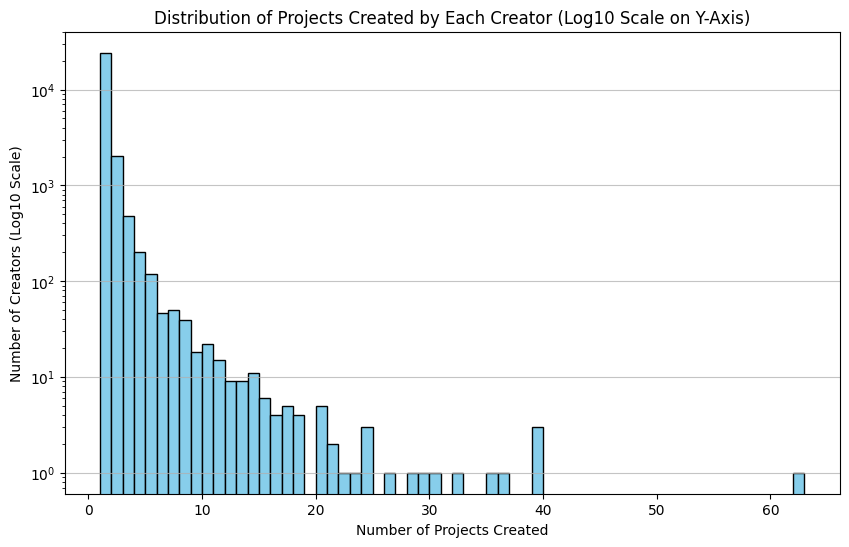

In [89]:
# Group by 'CreatorID' and count the number of 'ProjectID' for each creator
project_counts = df.groupby('CreatorID')['Project_CreatorID'].count()

# Plot the histogram of project counts per creator
plt.figure(figsize=(10, 6))
plt.hist(project_counts, bins=range(1, project_counts.max() + 1), color='skyblue', edgecolor='black', log=True)
plt.title('Distribution of Projects Created by Each Creator (Log10 Scale on Y-Axis)')
plt.xlabel('Number of Projects Created')
plt.ylabel('Number of Creators (Log10 Scale)')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

## Create IsFirsttimer

In [90]:
df['NoCreatorIdentified'] = df['ExtractedCreators'].notnull()

In [91]:
df['NoCreatorIdentified'].sum()

34013

In [92]:
# Create a dictionary from the project_counts Series
project_count_dict = project_counts.to_dict()

# Map the counts back to the original DataFrame to identify first-time creators
df['IsFirstTimer'] = df['CreatorID'].map(project_count_dict) == 1
# Map the project counts back to the original DataFrame
df['ProjectsByCreatorID'] = df['CreatorID'].map(project_counts)
# Calculate the number of first-time creators
num_first_time_creators = df['IsFirstTimer'].sum()

# Calculate the total number of creators
total_creators = df['CreatorID'].nunique()

# Calculate the proportion of first-time creators
proportion_first_time = num_first_time_creators / total_creators

# Print the proportion of first-time creators
print(f"Proportion of first-time creators: {proportion_first_time:.2f}")


Proportion of first-time creators: 0.89


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 97 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  56216 non-null  int64         
 1   ProjectID                   56216 non-null  int64         
 2   Subcategories               56216 non-null  object        
 3   URL                         56216 non-null  object        
 4   State                       56216 non-null  bool          
 5   ProjectName                 56215 non-null  object        
 6   ProjectDescription          56167 non-null  object        
 7   CreatorName                 56202 non-null  object        
 8   LastUpdate                  56215 non-null  datetime64[ns]
 9   UpdateCount                 56216 non-null  int64         
 10  CommentCount                56216 non-null  int64         
 11  ProWeLove                   56216 non-null  bool      

In [94]:
df.to_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_beforeracegender_usd.xlsx', index=False)

In [125]:
df=pd.read_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_beforeracegender_usd.xlsx')

# Create FirestName_new,LastName_new of SingleCreator(the extracted Creator) and FirstNameVerified,LastNameVerified for the Verified(the Verified identity)

In [126]:
df[['ProjectID', 'Project_CreatorID','CreatorID','SingleCreator','Verified']].head(50)

,ProjectID,Project_CreatorID,CreatorID,SingleCreator,Verified
0,3,NaN,NaN,NaN,Yee Him Hsu
1,7,7_Jadelabo_20210405,Jadelabo_20210405,Jadelabo,QIUYU WU
2,8,NaN,NaN,NaN,Norston Fontaine
3,11,11_Jeffrey Martin_20110928,Jeffrey Martin_20110928,Jeffrey Martin,Jeffrey Martin
4,15,15_Ryan Stout_20120328,Ryan Stout_20120328,Ryan Stout,Ryan Stout
5,21,NaN,NaN,NaN,Jason Gouw
6,28,28_Justin_20130901,Justin_20130901,Justin,Joel Johnson
7,28,28_Joel Johnson_20130901,Joel Johnson_20130901,Joel Johnson,Joel Johnson
8,29,NaN,NaN,NaN,Zaib Iqtidar
9,32,32_Nicholas Williams_20130324,Nicholas Williams_20130324,Nicholas Williams,NaN


In [127]:
# def extract_first_last(name):
#     if pd.isna(name): 
#         return [None, None]
#     parts = name.split()
#     if len(parts) == 1:  # Only one part in the name
#         first_name = parts[0]
#         last_name = parts[0]  # Treat the single name as both first and last name
#     else:
#         first_name = ' '.join(parts[:-1])
#         last_name = parts[-1]
#     return [first_name, last_name]



In [128]:
# Function to extract first and last names 
def extract_first_last(name):
    if pd.isna(name): 
        return [None, None]
    parts = name.split()
    first_name = ' '.join(parts[:-1]) if len(parts) > 1 else parts[0]
    last_name = parts[-1] if len(parts) > 1 else None
    return [first_name, last_name]

In [129]:
df['IsNameMatch'] = (df['SingleCreator'].str.lower() == df['Verified'].str.lower()).astype(bool)

## Testing

In [130]:
# Creating a test DataFrame
df_test = pd.DataFrame({'Verified': ['John Doe', 'Jane', 'Elon Reeve Musk', 'Shing Yin Khor', pd.NA]})

# Applying the function and creating new columns for first and last names
df_test[['FirstName', 'LastName']] = df_test.apply(lambda x: extract_first_last(x['Verified']), axis=1, result_type='expand')

print(df_test)


          Verified   FirstName LastName
0         John Doe        John      Doe
1             Jane        Jane     None
2  Elon Reeve Musk  Elon Reeve     Musk
3   Shing Yin Khor   Shing Yin     Khor
4             <NA>        None     None


In [132]:
df[['FirstNameVerified', 'LastNameVerified']] = df['Verified'].apply(lambda x: pd.Series(extract_first_last(x))) 
# Apply the function and assign results to new columns
df[['FirstName_new', 'LastName_new']] = df['SingleCreator'].apply(lambda x: pd.Series(extract_first_last(x))) 

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 102 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [134]:
selected_columns = df[['ProjectID', 'Project_CreatorID','CreatorID','SingleCreator','Verified','FirstNameVerified', 'LastNameVerified','LastName_new', 'FirstName_new']]
print(selected_columns .info())
selected_columns.to_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/CreatorName0408_usd.xlsx', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ProjectID          56216 non-null  int64 
 1   Project_CreatorID  34013 non-null  object
 2   CreatorID          34013 non-null  object
 3   SingleCreator      34013 non-null  object
 4   Verified           55207 non-null  object
 5   FirstNameVerified  55207 non-null  object
 6   LastNameVerified   55206 non-null  object
 7   LastName_new       30589 non-null  object
 8   FirstName_new      34013 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.9+ MB
None


# Generated Race columns using Python 'ethnicolr'

In [135]:
new_selected_columns=selected_columns.copy()
predictions_new = pred_wiki_name(new_selected_columns, 'LastName_new', 'FirstName_new')
predictions_verified = pred_wiki_name(new_selected_columns, 'LastNameVerified', 'FirstNameVerified')
print(predictions_new.info(),predictions_verified.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24034 entries, 0 to 24033
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ProjectID                              24034 non-null  int64  
 1   Project_CreatorID                      24034 non-null  object 
 2   CreatorID                              24034 non-null  object 
 3   SingleCreator                          24034 non-null  object 
 4   Verified                               23494 non-null  object 
 5   FirstNameVerified                      23494 non-null  object 
 6   LastNameVerified                       23494 non-null  object 
 7   LastName_new                           24034 non-null  object 
 8   FirstName_new                          24034 non-null  object 
 9   Asian,GreaterEastAsian,EastAsian       24034 non-null  float32
 10  Asian,GreaterEastAsian,Japanese        24034 non-null  float32
 11  As

In [136]:
predictions_new['newrace'] = predictions_new['race']
predictions_verified['verifiedrace'] = predictions_verified['race']
race_mapping = {
    'GreaterEuropean,Jewish': 'white',
    'GreaterAfrican,Africans': 'black',
    'GreaterEuropean,British': 'white',
    'GreaterEuropean,WestEuropean,Nordic': 'white',
    'GreaterEuropean,WestEuropean,French': 'white',
    'Asian,IndianSubContinent': 'asian',
    'Asian,GreaterEastAsian,EastAsian': 'asian',
    'GreaterEuropean,EastEuropean': 'white',
    'GreaterEuropean,WestEuropean,Italian': 'white',
    'Asian,GreaterEastAsian,Japanese': 'asian',
    'GreaterEuropean,WestEuropean,Hispanic': 'hispanic',
    'GreaterAfrican,Muslim': 'black',
    'GreaterEuropean,WestEuropean,Germanic': 'white',
    # Add more mappings as needed
}

# Apply the mapping to normalize the race categories
predictions_new['race'] = predictions_new['race'].map(lambda x: race_mapping.get(x, 'other'))
predictions_verified['race'] = predictions_verified['race'].map(lambda x: race_mapping.get(x, 'other'))
# Rename 'race' to 'CreatorNameRace'
predictions_new.rename(columns={'race':'EthClrCreatorNameRace'}, inplace=True)
predictions_verified.rename(columns={'race': 'EthClrVerifiedNameRace'}, inplace=True)

merged_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 108 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-null  bool          
 12   ProjectLocation             56216 non-null  object        
 13   Pledged                     55747 non-null  float64       
 14   Goal                        55755 non-null  float64       
 15   ImgCount                    56216 non-null  int64         
 16   videoCount                  56216 non-null  int64         
 17   youtubeCount                56216 non-null  int64         
 18   Backer                      56195 non-null  float64       
 19   StartDate                   56216 non-null  datetime64[ns]
 20   EndDate                     56216 non-null  datetime64[ns]
 21   Days                        56216 non-null  int64         
 22   Featured                    252 non-null    object        
 23   Story                       56216 non-null  object        
 24   CreatorLocation             55613 non-null  object        
 25   Verified                    55207 non-null  object        
 26   CreatorURL                  56173 non-null  object        
 27   Connect                     56173 non-null  object        
 28   Text                        56173 non-null  object        
 29   Biography                   54987 non-null  object        
 30   backed                      54987 non-null  float64       
 31   joined                      54987 non-null  datetime64[ns]
 32   create                      54987 non-null  float64       
 33   webList                     40978 non-null  object        
 34   Category                    56216 non-null  object        
 35   WebNum                      56216 non-null  int64         
 36   IsFeatured                  56216 non-null  bool          
 37   IsConnect                   56216 non-null  bool          
 38   TotalCreated                56173 non-null  float64       
 39   TotalBacked                 56173 non-null  float64       
 40   IsIdentityVerified          56216 non-null  bool          
 41   IsVerifiedIDAvailable       56216 non-null  bool          
 42   Pledged_USD                 1011 non-null   float64       
 43   Goal_USD                    1016 non-null   float64       
 44   Education_Context           56216 non-null  object        
 45   High_Educated_Bio           56216 non-null  bool          
 46   Education_Level             56216 non-null  object        
 47   Description                 56216 non-null  object        
 48   DescriptionLength           56216 non-null  int64         
 49   DescriptionSentiment        56216 non-null  float64       
 50   DescriptionClarity          56216 non-null  float64       
 51   Supportiveness              55730 non-null  float64       
 52   Video_in_Description        56216 non-null  int64         
 53   Total pledges               55747 non-null  float64       
 54   Time span                   56216 non-null  float64       
 55   Financing goal              55755 non-null  float64       
 56   Log_DescriptionLength       56216 non-null  float64       
 57   YearStartDate               56216 non-null  int64         
 58   MonthStartDate              56216 non-null  int64         
 59   DayStartDate                56216 non-null  int64         
 60   YearEndDate                 56216 non-null  int64         
 61   MonthEndDate                56216 non-null  int64         
 62   DayEndDate                  56216 non-null  int64         
 63   ProLocationState            56216 non-null  object        
 64   CreatorLocationState        55613 non-null  object        
 65   IsLocationMatch             56216 non-null  bool          
 66   IsDomesticCreator           56216 non-null  bool          
 67   RewardDescript              56042 non-null  object        
 68   EstimatedDelivery           56042 non-null  object        
 69   RewardName                  56042 non-null  object        
 70   Amount                      56042 non-null  object        
 71   BackersNum                  56042 non-null  object        
 72   Status                      56042 non-null  object        
 73   IsRewardUSD                 56216 non-null  bool          
 74   IsPledgedGoalUSD            56216 non-null  bool          
 75   IsProjectUSD                56216 non-null  bool          
 76   RewardNum                   56216 non-null  int64         
 77   AverageAmount               56042 non-null  float64       
 78   AverageDeliveryTime         56042 non-null  float64       
 79   AvailableRewards            56042 non-null  float64       
 80   CombinedRewardDescription   56042 non-null  object        
 81   RewardDescriptionSentiment  56216 non-null  float64       
 82   RewardDescriptionClarity    56216 non-null  float64       
 83   RewardDescriptionLength     56216 non-null  int64         
 84   RaceKeywords                14634 non-null  object        
 85   IsRaceMentioned             56216 non-null  bool          
 86   KeywordOccurrences          14634 non-null  object        
 87   ExtractedCreators           34013 non-null  object        
 88   Organization_Context        56216 non-null  object        
 89   IsOrganization              56216 non-null  bool          
 90   CoCreatorNum                56216 non-null  int64         
 91   SingleCreator               34013 non-null  object        
 92   CreatorID                   34013 non-null  object        
 93   Project_CreatorID           34013 non-null  object        
 94   NoCreatorIdentified         56216 non-null  bool          
 95   IsFirstTimer                56216 non-null  bool          
 96   ProjectsByCreatorID         34013 non-null  float64       
 97   IsNameMatch                 56216 non-null  bool          
 98   FirstNameVerified           55207 non-null  object        
 99   LastNameVerified            55206 non-null  object        
 100  FirstName_new               34013 non-null  object        
 101  LastName_new                30589 non-null  object        
 102  EthClrCreatorNameRace       24034 non-null  object        
 103  newrace                     24034 non-null  object        
 104  verifiedrace                22569 non-null  object        
 105  EthClrVerifiedNameRace      22569 non-null  object        
 106  PyEthCreatorNameRace        56216 non-null  object        
 107  PyEthVerifiedNameRace       56216 non-null  object        
dtypes: bool(17), datetime64[ns](4), float64(22), int64(20), object(45)
memory usage: 39.9+ MB

In [137]:
print(predictions_new.info(),predictions_verified.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24034 entries, 0 to 24033
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ProjectID                              24034 non-null  int64  
 1   Project_CreatorID                      24034 non-null  object 
 2   CreatorID                              24034 non-null  object 
 3   SingleCreator                          24034 non-null  object 
 4   Verified                               23494 non-null  object 
 5   FirstNameVerified                      23494 non-null  object 
 6   LastNameVerified                       23494 non-null  object 
 7   LastName_new                           24034 non-null  object 
 8   FirstName_new                          24034 non-null  object 
 9   Asian,GreaterEastAsian,EastAsian       24034 non-null  float32
 10  Asian,GreaterEastAsian,Japanese        24034 non-null  float32
 11  As

# Generated Race columns using Python 'pyethnicity'

In [138]:
new_selected_columns=selected_columns.copy()
new_selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ProjectID          56216 non-null  int64 
 1   Project_CreatorID  34013 non-null  object
 2   CreatorID          34013 non-null  object
 3   SingleCreator      34013 non-null  object
 4   Verified           55207 non-null  object
 5   FirstNameVerified  55207 non-null  object
 6   LastNameVerified   55206 non-null  object
 7   LastName_new       30589 non-null  object
 8   FirstName_new      34013 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.9+ MB


In [139]:
def predict_race(df, first_name_col, last_name_col):
    """
    Predicts races based on first and last names from specified DataFrame columns.

    Parameters:
    - df: pandas DataFrame containing the data.
    - first_name_col: The name of the column containing first names.
    - last_name_col: The name of the column containing last names.

    Returns:
    - A list of race predictions.
    """
    # Check if specified columns exist in the DataFrame
    if first_name_col not in df.columns or last_name_col not in df.columns:
        raise ValueError("Specified columns do not exist in DataFrame")

    # Replace None with empty strings in first and last name columns
    df[first_name_col] = df[first_name_col].fillna('')
    df[last_name_col] = df[last_name_col].fillna('')

    # Prepare lists for first and last names
    first_names = df[first_name_col].tolist()
    last_names = df[last_name_col].tolist()

    # Assuming predict_race_fl can process lists and return a list of predictions
    # Replace 'pyethnicity.predict_race_fl' with the correct function call if different
    predictions = pyethnicity.predict_race_fl(first_name=first_names, last_name=last_names)

    return predictions





In [140]:
# Example usage (make sure 'new_gr' is a valid DataFrame and column names are correct)
results_new= predict_race(new_selected_columns, 'FirstName_new', 'LastName_new')
results_Verified = predict_race(new_selected_columns, 'FirstNameVerified', 'LastNameVerified')

C:\Users\youxi\anaconda3\envs\bar\lib\site-packages\pyethnicity\_ml_models.py:71: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  pl.Series(values=name)
100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [10:15<00:00, 11.20s/it]
C:\Users\youxi\anaconda3\envs\bar\lib\site-packages\pyethnicity\_ml_models.py:71: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  pl.Series(values=name)
100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [09:50<00:00, 10.74s/it]


In [141]:
# Merge results with the original DataFrame based on index
RacePrediction_CN = new_selected_columns.join(results_new)

# Merge results with the original DataFrame based on index
RacePrediction_Verified = new_selected_columns.join(results_Verified)

In [142]:
print(RacePrediction_CN.info(),RacePrediction_Verified.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProjectID          56216 non-null  int64  
 1   Project_CreatorID  34013 non-null  object 
 2   CreatorID          34013 non-null  object 
 3   SingleCreator      34013 non-null  object 
 4   Verified           55207 non-null  object 
 5   FirstNameVerified  56216 non-null  object 
 6   LastNameVerified   56216 non-null  object 
 7   LastName_new       56216 non-null  object 
 8   FirstName_new      56216 non-null  object 
 9   first_name         56216 non-null  object 
 10  last_name          56216 non-null  object 
 11  asian              56216 non-null  float32
 12  black              56216 non-null  float32
 13  hispanic           56216 non-null  float32
 14  white              56216 non-null  float32
dtypes: float32(4), int64(1), object(10)
memory usage: 5.6+ MB
<class 'pand

In [143]:
RacePrediction_CN.head()

,ProjectID,Project_CreatorID,CreatorID,SingleCreator,Verified,FirstNameVerified,LastNameVerified,LastName_new,FirstName_new,first_name,last_name,asian,black,hispanic,white
0,3,NaN,NaN,NaN,Yee Him Hsu,Yee Him,Hsu,,,,,0.992312,0.002898,0.004040,0.000750
1,7,7_Jadelabo_20210405,Jadelabo_20210405,Jadelabo,QIUYU WU,QIUYU,WU,,Jadelabo,Jadelabo,,0.884946,0.090497,0.010325,0.014231
2,8,NaN,NaN,NaN,Norston Fontaine,Norston,Fontaine,,,,,0.992312,0.002898,0.004040,0.000750
3,11,11_Jeffrey Martin_20110928,Jeffrey Martin_20110928,Jeffrey Martin,Jeffrey Martin,Jeffrey,Martin,Martin,Jeffrey,Jeffrey,Martin,0.015725,0.119073,0.013428,0.851775
4,15,15_Ryan Stout_20120328,Ryan Stout_20120328,Ryan Stout,Ryan Stout,Ryan,Stout,Stout,Ryan,Ryan,Stout,0.026194,0.053226,0.010015,0.910565


In [144]:
RacePrediction_Verified.head()

,ProjectID,Project_CreatorID,CreatorID,SingleCreator,Verified,FirstNameVerified,LastNameVerified,LastName_new,FirstName_new,first_name,last_name,asian,black,hispanic,white
0,3,NaN,NaN,NaN,Yee Him Hsu,Yee Him,Hsu,,,Yee Him,Hsu,0.999606,0.000270,0.000122,0.000002
1,7,7_Jadelabo_20210405,Jadelabo_20210405,Jadelabo,QIUYU WU,QIUYU,WU,,Jadelabo,QIUYU,WU,0.999867,0.000030,0.000100,0.000002
2,8,NaN,NaN,NaN,Norston Fontaine,Norston,Fontaine,,,Norston,Fontaine,0.019102,0.546453,0.017829,0.416616
3,11,11_Jeffrey Martin_20110928,Jeffrey Martin_20110928,Jeffrey Martin,Jeffrey Martin,Jeffrey,Martin,Martin,Jeffrey,Jeffrey,Martin,0.015725,0.119073,0.013428,0.851775
4,15,15_Ryan Stout_20120328,Ryan Stout_20120328,Ryan Stout,Ryan Stout,Ryan,Stout,Stout,Ryan,Ryan,Stout,0.026194,0.053226,0.010015,0.910565


In [145]:
# Finding the column with the maximum value in the race categories
race_columns = ['asian', 'black', 'hispanic', 'white']
RacePrediction_CN['PyEthCreatorNameRace'] = RacePrediction_CN[race_columns].idxmax(axis=1)
RacePrediction_Verified['PyEthVerifiedNameRace'] = RacePrediction_Verified[race_columns].idxmax(axis=1)


In [146]:
print(RacePrediction_CN.info(),RacePrediction_Verified.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProjectID             56216 non-null  int64  
 1   Project_CreatorID     34013 non-null  object 
 2   CreatorID             34013 non-null  object 
 3   SingleCreator         34013 non-null  object 
 4   Verified              55207 non-null  object 
 5   FirstNameVerified     56216 non-null  object 
 6   LastNameVerified      56216 non-null  object 
 7   LastName_new          56216 non-null  object 
 8   FirstName_new         56216 non-null  object 
 9   first_name            56216 non-null  object 
 10  last_name             56216 non-null  object 
 11  asian                 56216 non-null  float32
 12  black                 56216 non-null  float32
 13  hispanic              56216 non-null  float32
 14  white                 56216 non-null  float32
 15  PyEthCreatorNameRac

## Merged Race columns predicted by python

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 102 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [159]:
# Group by 'ProjectID' and count unique 'Verified' values
verification_counts = merged_df.groupby('ProjectID')['Verified'].nunique()

# Check if any counts are greater than 1
if (verification_counts > 1).any():
    print("There are projectids with non-unique 'verified' values.")
    print("Project IDs with non-unique 'verified' values:")
    print(verification_counts[verification_counts > 1])
else:
    print("Each unique projectid has a unique 'verified' value.")

Each unique projectid has a unique 'verified' value.


In [151]:
# Merge updated race information into merged_df
merged_df = pd.merge(df, predictions_new[['ProjectID','CreatorID', 'EthClrCreatorNameRace', 'newrace']], 
                     on=['ProjectID','CreatorID'], how='left')
merged_df.info()
# Check the result
print(merged_df.info())
merged_df = pd.merge(merged_df, predictions_verified[['ProjectID','CreatorID', 'verifiedrace', 'EthClrVerifiedNameRace']], 
                     on=['ProjectID','CreatorID'], how='left')

# Check the result
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 104 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [152]:
# Merge updated race information into merged_df
merged_df = pd.merge(merged_df, RacePrediction_CN[['ProjectID', 'CreatorID', 'PyEthCreatorNameRace']], 
                     on=['ProjectID', 'CreatorID'], how='left')
# Check the result
print(merged_df.info())  
merged_df = pd.merge(merged_df,RacePrediction_Verified[['ProjectID','CreatorID','PyEthVerifiedNameRace']], 
                     on=['ProjectID', 'CreatorID'], how='left')

# Check the result
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 107 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [153]:
merged_df.to_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_beforeR_usd.xlsx', index=False)

In [282]:
merged_df=pd.read_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/kickstarter_beforeR_usd.xlsx')

# Testing

In [283]:
# Select a random sample of ProjectID and CreatorID values from df
sample_project_creator_ids = merged_df[['ProjectID', 'CreatorID']].sample(n=1)

# Print the selected ProjectID and CreatorID values
print("Random sample of ProjectID and CreatorID from dataframe (meged_df):")
sample_project_creator_ids



Random sample of ProjectID and CreatorID from dataframe (meged_df):


,ProjectID,CreatorID
3115,5597,Phillip_20140716


In [284]:
# Check the corresponding values in the merged dataframe
print("\nCorresponding values in the merged dataframe (merged_df):")
for project_id, creator_id in sample_project_creator_ids.values:
    sample_row = merged_df.loc[(merged_df['ProjectID'] == project_id) & (merged_df['CreatorID'] == creator_id)]
sample_row[['ProjectID', 'CreatorID', 'EthClrCreatorNameRace', 'newrace', 'verifiedrace', 'EthClrVerifiedNameRace',
                      'PyEthCreatorNameRace', 'PyEthVerifiedNameRace']]


Corresponding values in the merged dataframe (merged_df):


,ProjectID,CreatorID,EthClrCreatorNameRace,newrace,verifiedrace,EthClrVerifiedNameRace,PyEthCreatorNameRace,PyEthVerifiedNameRace
3115,5597,Phillip_20140716,NaN,NaN,NaN,NaN,asian,white


In [285]:
# predictions_new = pd.DataFrame(predictions_new)

In [286]:
# Check the corresponding values in predictions_new
print("\nCorresponding values in predictions_new:")
for project_id, creator_id in sample_project_creator_ids.values:
    sample_row = predictions_new.loc[(predictions_new['ProjectID'] == project_id) & (predictions_new['CreatorID'] == creator_id)]
    print(sample_row[['ProjectID', 'CreatorID', 'EthClrCreatorNameRace', 'newrace']])


Corresponding values in predictions_new:
Empty DataFrame
Columns: [ProjectID, CreatorID, EthClrCreatorNameRace, newrace]
Index: []


In [287]:
# Check the corresponding values in predictions_verified
print("\nCorresponding values in predictions_verified:")
for project_id, creator_id in sample_project_creator_ids.values:
    sample_row = predictions_verified.loc[(predictions_verified['ProjectID'] == project_id) & (predictions_verified['CreatorID'] == creator_id)]
    print(sample_row[['ProjectID', 'CreatorID', 'verifiedrace', 'EthClrVerifiedNameRace']])


Corresponding values in predictions_verified:
Empty DataFrame
Columns: [ProjectID, CreatorID, verifiedrace, EthClrVerifiedNameRace]
Index: []


In [288]:
# Check the corresponding values in RacePrediction_CN
print("\nCorresponding values in RacePrediction_CN:")
for project_id, creator_id in sample_project_creator_ids.values:
    sample_row = RacePrediction_CN.loc[(RacePrediction_CN['ProjectID'] == project_id) & (RacePrediction_CN['CreatorID'] == creator_id)]
sample_row[['ProjectID', 'CreatorID', 'PyEthCreatorNameRace']]


Corresponding values in RacePrediction_CN:


,ProjectID,CreatorID,PyEthCreatorNameRace
3115,5597,Phillip_20140716,asian


In [289]:
# # Check the corresponding values in the merged dataframe
# print("\nCorresponding values in the merged dataframe (merged_df):")
# for project_id, creator_id in sample_project_creator_ids.values:
#     sample_row = merged_df.loc[(merged_df['ProjectID'] == project_id) & (merged_df['CreatorID'] == creator_id)]
#     print(sample_row[['ProjectID', 'CreatorID', 'EthClrCreatorNameRace', 'newrace', 'verifiedrace', 'EthClrVerifiedNameRace',
#                       'PyEthCreatorNameRace', 'PyEthVerifiedNameRace']])

In [291]:
# Check the corresponding values in RacePrediction_Verified
print("\nCorresponding values in RacePrediction_Verified:")
for project_id, creator_id in sample_project_creator_ids.values:
    sample_row = RacePrediction_Verified.loc[(RacePrediction_Verified['ProjectID'] == project_id) & (RacePrediction_Verified['CreatorID'] == creator_id)]
sample_row[['ProjectID', 'CreatorID', 'PyEthVerifiedNameRace']]




Corresponding values in RacePrediction_Verified:


,ProjectID,CreatorID,PyEthVerifiedNameRace
3115,5597,Phillip_20140716,white


# Generated Race and Gender related columns using R

In [292]:
gr=pd.read_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/selected_columns_with_predictions_0421_usd.xlsx')
gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProjectID               56216 non-null  int64 
 1   Project_CreatorID       34013 non-null  object
 2   CreatorID               34013 non-null  object
 3   SingleCreator           34013 non-null  object
 4   Verified                55207 non-null  object
 5   FirstNameVerified       55207 non-null  object
 6   LastNameVerified        55206 non-null  object
 7   LastName_new            30589 non-null  object
 8   FirstName_new           34013 non-null  object
 9   LiklyRaceLast           26090 non-null  object
 10  LiklyRaceFirst          25998 non-null  object
 11  LiklyRace               31496 non-null  object
 12  LiklyGender_new         29314 non-null  object
 13  LiklyRaceVerifiedLast   47990 non-null  object
 14  LiklyRaceVerifiedFirst  42925 non-null  object
 15  Li

## Merged Race and Gender columns predicted by R

In [293]:
print("Unique values in 'LiklyRace' column:")
print(gr['LiklyRace'].unique())
print("\nUnique values in 'LiklyGender_new' column:")
print(gr['LiklyGender_new'].unique())

print("\nUnique values in 'LiklyRaceVerified' column:")
print(gr['LiklyRaceVerified'].unique())
print("\nUnique values in 'LiklyGenderVerified' column:")
print(gr['LiklyGenderVerified'].unique())

Unique values in 'LiklyRace' column:
[nan 'white' 'black' 'hispanic' 'asian' 'american_indian' 'asian, white']

Unique values in 'LiklyGender_new' column:
[nan 'male' 'female' 'female, male']

Unique values in 'LiklyRaceVerified' column:
['asian' 'white' nan 'hispanic' 'black' 'american_indian' 'asian, black'
 'black, white']

Unique values in 'LiklyGenderVerified' column:
[nan 'male' 'female' 'female, male']


In [294]:
#  prioritizing 'black'
gr['PrdTrcCreatorNameRace'] = gr['LiklyRace'].apply(lambda x: 'black' if pd.notnull(x) and 'black' in str(x) else (x.split(',')[0].strip() if pd.notnull(x) else np.nan))

gr['PrdTrcVerifiedNameRace'] = gr['LiklyRaceVerified'].apply(lambda x: 'black' if pd.notnull(x) and 'black' in str(x) else (x.split(',')[0].strip() if pd.notnull(x) else np.nan))
# Replace 'american_indian' with 'asian' in multiple columns
columns_to_replace = ['PrdTrcCreatorNameRace', 'PrdTrcVerifiedNameRace']
gr[columns_to_replace] = gr[columns_to_replace].replace('american_indian', 'asian', regex=True)
# Create a new column 'Gender' prioritizing 'female'
gr['PrdTrcCreatorNameGender'] = gr['LiklyGender_new'].apply(lambda x:  'female' if pd.notnull(x) and 'female' in str(x)  else (x.split(',')[0].strip() if pd.notnull(x) else np.nan))
# Create a new column 'Gender' prioritizing 'female'
gr['PrdTrcVerifiedNameGender'] = gr['LiklyGenderVerified'].apply(lambda x:  'female' if pd.notnull(x) and 'female' in str(x)  else (x.split(',')[0].strip() if pd.notnull(x) else np.nan))


print("Unique values in PrdTrcCreatorNameRace' column:")
print(gr['PrdTrcCreatorNameRace'].unique())
print("\nUnique values in 'PrdTrcCreatorNameGender' column:")
print(gr['PrdTrcCreatorNameGender'].unique())


print("Unique values in 'PrdTrcVerifiedNameRace' column:")
print(gr['PrdTrcVerifiedNameRace'].unique())
print("\nUnique values in 'PrdTrcVerifiedNameGender' column:")
print(gr['PrdTrcVerifiedNameGender'].unique())


Unique values in PrdTrcCreatorNameRace' column:
[nan 'white' 'black' 'hispanic' 'asian']

Unique values in 'PrdTrcCreatorNameGender' column:
[nan 'male' 'female']
Unique values in 'PrdTrcVerifiedNameRace' column:
['asian' 'white' nan 'hispanic' 'black']

Unique values in 'PrdTrcVerifiedNameGender' column:
[nan 'male' 'female']


In [295]:
gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ProjectID                 56216 non-null  int64 
 1   Project_CreatorID         34013 non-null  object
 2   CreatorID                 34013 non-null  object
 3   SingleCreator             34013 non-null  object
 4   Verified                  55207 non-null  object
 5   FirstNameVerified         55207 non-null  object
 6   LastNameVerified          55206 non-null  object
 7   LastName_new              30589 non-null  object
 8   FirstName_new             34013 non-null  object
 9   LiklyRaceLast             26090 non-null  object
 10  LiklyRaceFirst            25998 non-null  object
 11  LiklyRace                 31496 non-null  object
 12  LiklyGender_new           29314 non-null  object
 13  LiklyRaceVerifiedLast     47990 non-null  object
 14  LiklyRaceVerifiedFirst

In [296]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 108 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [297]:
gr.columns

Index(['ProjectID', 'Project_CreatorID', 'CreatorID', 'SingleCreator',
       'Verified', 'FirstNameVerified', 'LastNameVerified', 'LastName_new',
       'FirstName_new', 'LiklyRaceLast', 'LiklyRaceFirst', 'LiklyRace',
       'LiklyGender_new', 'LiklyRaceVerifiedLast', 'LiklyRaceVerifiedFirst',
       'LiklyRaceVerified', 'LiklyGenderVerified', 'PrdTrcCreatorNameRace',
       'PrdTrcVerifiedNameRace', 'PrdTrcCreatorNameGender',
       'PrdTrcVerifiedNameGender'],
      dtype='object')

#1   Project_CreatorID         34013 non-null  object
 2   CreatorID                 34013 non-null  object
 3   SingleCreator             34013 non-null  object
 4   Verified                  55207 non-null  object
 5   FirstNameVerified         55207 non-null  object
 6   LastNameVerified          55206 non-null  object
 7   LastName_new              30589 non-null  object
 8   FirstName_new             34013 non-null  object
 9   LiklyRaceLast             26090 non-null  object
 10  LiklyRaceFirst            25998 non-null  object
 11  LiklyRace                 25998 non-null  object
 12  LiklyGender_new           29314 non-null  object
 13  LiklyRaceVerifiedLast     47990 non-null  object
 14  LiklyRaceVerifiedFirst    42925 non-null  object
 15  LiklyRaceVerified         53111 non-null  object
 16  LiklyGenderVerified       47567 non-null  object
 17  PrdTrcCreatorNameRace     25998 non-null  object
 18  PrdTrcVerifiedNameRace    53111 non-null  object
 19  PrdTrcCreatorNameGender   29314 non-null  object
 20  PrdTrcVerifiedNameGender  47567 non-null  object

In [298]:
# Merge the relevant columns into merged_df based on 'ProjectID','CreatorID'
All_df = pd.merge(merged_df, gr[['ProjectID', 'CreatorID',
                                  'LiklyRace', 'LiklyGender_new',
                                  'LiklyRaceVerified', 'LiklyGenderVerified', 
                         'PrdTrcCreatorNameRace',
       'PrdTrcVerifiedNameRace', 'PrdTrcCreatorNameGender',
       'PrdTrcVerifiedNameGender']], 
                     on=['ProjectID', 'CreatorID'],
                     how='left')



In [299]:
# Temporarily adjust option to display up to 500 columns 
pd.set_option('display.max_info_columns', 500)
All_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 116 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [300]:
def get_major_race_revised(race_list):
    # Filter out NaN values
    valid_races = [race for race in race_list if pd.notna(race)]
    # Count the frequency of each race
    race_counts = {race: valid_races.count(race) for race in set(valid_races)}
    # Find the race(s) with the highest frequency
    max_count = max(race_counts.values(), default=0)
    # Ensure the most frequent race appears at least twice
    if max_count >= 2:
        # Return the first race that matches the max count (assuming no ties for simplicity)
        for race, count in race_counts.items():
            if count == max_count:
                return race
    return np.nan

# Apply the revised function to compute 'MajorRaceCreator' and 'MajorRaceVerified'
All_df['MajorCreatorNameRace'] = All_df.apply(lambda row: get_major_race_revised([row['EthClrCreatorNameRace'], row['PyEthCreatorNameRace'], row['PrdTrcCreatorNameRace']]), axis=1)
All_df['MajorVerifiedNameRace'] = All_df.apply(lambda row: get_major_race_revised([row['EthClrVerifiedNameRace'], row['PyEthVerifiedNameRace'], row['PrdTrcVerifiedNameRace']]), axis=1)

In [301]:
# Check the result
print(All_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 118 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [302]:
filtered_df = All_df[All_df['CreatorID'].notna()]
sample_columns = [
    'ProjectID', 'CreatorID', 'SingleCreator', 'IsNameMatch',
    'CreatorName', 'ExtractedCreators','Verified',
    'PrdTrcCreatorNameGender', 'PrdTrcVerifiedNameGender',
    'FirstName_new', 'LastName_new',
    'EthClrCreatorNameRace', 'PyEthCreatorNameRace','PrdTrcCreatorNameRace', 'MajorCreatorNameRace', 
     'FirstNameVerified', 'LastNameVerified', 
    'EthClrVerifiedNameRace', 'PyEthVerifiedNameRace',  'PrdTrcVerifiedNameRace','MajorVerifiedNameRace'

]

# Randomly select 350 rows from the filtered DataFrame for the sanity check
sanity_check_sample = filtered_df[sample_columns].sample(n=350, random_state=1)

sanity_check_sample.to_excel('D:/trykicstarter/Kickstarter_0419/data/2.Filtered/sanity_check_1_usd.xlsx', index=False)

In [303]:
All_df.columns

Index(['Unnamed: 0', 'ProjectID', 'Subcategories', 'URL', 'State',
       'ProjectName', 'ProjectDescription', 'CreatorName', 'LastUpdate',
       'UpdateCount',
       ...
       'LiklyRace', 'LiklyGender_new', 'LiklyRaceVerified',
       'LiklyGenderVerified', 'PrdTrcCreatorNameRace',
       'PrdTrcVerifiedNameRace', 'PrdTrcCreatorNameGender',
       'PrdTrcVerifiedNameGender', 'MajorCreatorNameRace',
       'MajorVerifiedNameRace'],
      dtype='object', length=118)

# Store a final file 

In [304]:
All_df = All_df.drop(columns=['Unnamed: 0'])

In [305]:

All_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 117 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    ProjectID                   56216 non-null  int64         
 1    Subcategories               56216 non-null  object        
 2    URL                         56216 non-null  object        
 3    State                       56216 non-null  bool          
 4    ProjectName                 56215 non-null  object        
 5    ProjectDescription          56167 non-null  object        
 6    CreatorName                 56202 non-null  object        
 7    LastUpdate                  56215 non-null  datetime64[ns]
 8    UpdateCount                 56216 non-null  int64         
 9    CommentCount                56216 non-null  int64         
 10   ProWeLove                   56216 non-null  bool          
 11   ProjectLocation             56216 non-n

In [306]:
#"D:\trykicstarter\Kickstarter_0319\data\3.Final"
All_df.to_excel('D:/trykicstarter/Kickstarter_0419/data/3.Final/kickstarter_creator_v4_usd_0421.xlsx',index=True)

# Create a final file with key variables

In [307]:
df=pd.read_excel('D:/trykicstarter/Kickstarter_0419/data/3.Final/kickstarter_creator_v4_usd_0421.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 118 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [308]:
# Define the columns to replace values in
columns_to_replace = [ 'PrdTrcCreatorNameGender', 'PrdTrcVerifiedNameGender',
       'EthClrCreatorNameRace', 'PyEthCreatorNameRace',
       'PrdTrcCreatorNameRace', 'MajorCreatorNameRace',
                     'EthClrVerifiedNameRace', 'PyEthVerifiedNameRace',
       'PrdTrcVerifiedNameRace', 'MajorVerifiedNameRace',]
# Print unique values after replacement
for column in columns_to_replace:
    print(f"Unique values in '{column}' column:")
    print(df[column].unique())
    print()

Unique values in 'PrdTrcCreatorNameGender' column:
[nan 'male' 'female']

Unique values in 'PrdTrcVerifiedNameGender' column:
[nan 'male' 'female']

Unique values in 'EthClrCreatorNameRace' column:
[nan 'white' 'hispanic' 'asian' 'black']

Unique values in 'PyEthCreatorNameRace' column:
['asian' 'white' 'black' 'hispanic']

Unique values in 'PrdTrcCreatorNameRace' column:
[nan 'white' 'black' 'hispanic' 'asian']

Unique values in 'MajorCreatorNameRace' column:
[nan 'white' 'hispanic' 'asian' 'black']

Unique values in 'EthClrVerifiedNameRace' column:
[nan 'white' 'asian' 'hispanic' 'black']

Unique values in 'PyEthVerifiedNameRace' column:
['asian' 'black' 'white' 'hispanic']

Unique values in 'PrdTrcVerifiedNameRace' column:
['asian' 'white' nan 'hispanic' 'black']

Unique values in 'MajorVerifiedNameRace' column:
['asian' nan 'white' 'hispanic' 'black']



In [327]:
# Create a new DataFrame containing only the relevant columns
df_relevant = df[['ProjectID','CreatorName','ExtractedCreators','joined','SingleCreator', 'CreatorID', 'Project_CreatorID','IsFirstTimer',
                 'NoCreatorIdentified','ProjectsByCreatorID','FirstName_new','LastName_new', 'newrace', 'verifiedrace',  
                 'LiklyRace', 'LiklyGender_new', 
                 'LiklyRaceVerified', 'LiklyGenderVerified',] + columns_to_replace]
df_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ProjectID                 56216 non-null  int64         
 1   CreatorName               56202 non-null  object        
 2   ExtractedCreators         34013 non-null  object        
 3   joined                    54987 non-null  datetime64[ns]
 4   SingleCreator             34013 non-null  object        
 5   CreatorID                 34013 non-null  object        
 6   Project_CreatorID         34013 non-null  object        
 7   IsFirstTimer              56216 non-null  bool          
 8   NoCreatorIdentified       56216 non-null  bool          
 9   ProjectsByCreatorID       34013 non-null  float64       
 10  FirstName_new             34013 non-null  object        
 11  LastName_new              30589 non-null  object        
 12  newrace           

In [328]:
# Export the streamlined DataFrame to an Excel file for use in analysis+
df_relevant.to_excel('D:/trykicstarter/Kickstarter_0419/data/3.Final/kickstarter_CreatorID_v4_usd_0421.xlsx',index=True)

In [309]:
# Group by 'ProjectID' and aggregate unique sorted values for each specified column
aggregated_df = df_relevant.groupby(['ProjectID']).agg({
    **{column: lambda x: ', '.join(sorted(set(x.dropna().str.strip().str.lower()))) for column in columns_to_replace}
}).reset_index()

# Check the result
for column in columns_to_replace:
    print(f"Unique values in '{column}' column:")
    print(aggregated_df[column].unique())
    print()

Unique values in 'PrdTrcCreatorNameGender' column:
['' 'male' 'female' 'female, male']

Unique values in 'PrdTrcVerifiedNameGender' column:
['' 'male' 'female']

Unique values in 'EthClrCreatorNameRace' column:
['' 'white' 'hispanic' 'asian' 'hispanic, white' 'black' 'black, white'
 'asian, white' 'asian, black' 'asian, hispanic' 'black, hispanic']

Unique values in 'PyEthCreatorNameRace' column:
['asian' 'white' 'asian, white' 'black' 'hispanic' 'hispanic, white'
 'black, white' 'black, hispanic' 'asian, hispanic' 'asian, black'
 'asian, hispanic, white' 'asian, black, white']

Unique values in 'PrdTrcCreatorNameRace' column:
['' 'white' 'black' 'hispanic' 'asian' 'hispanic, white' 'asian, white'
 'black, white' 'asian, hispanic' 'asian, black']

Unique values in 'MajorCreatorNameRace' column:
['' 'white' 'hispanic' 'asian' 'hispanic, white' 'black' 'asian, white'
 'black, white' 'asian, hispanic' 'asian, black']

Unique values in 'EthClrVerifiedNameRace' column:
['' 'white' 'asian' '

In [310]:
# Replace '' with NaN and 'male, female' with 'female, male' in specified columns
replacement_mapping = {'': np.nan}
aggregated_df[columns_to_replace] = aggregated_df[columns_to_replace].replace(replacement_mapping)

# Print unique values after replacement
for column in columns_to_replace:
    print(f"Unique values in '{column}' column:")
    print(aggregated_df[column].unique())
    print()

Unique values in 'PrdTrcCreatorNameGender' column:
[nan 'male' 'female' 'female, male']

Unique values in 'PrdTrcVerifiedNameGender' column:
[nan 'male' 'female']

Unique values in 'EthClrCreatorNameRace' column:
[nan 'white' 'hispanic' 'asian' 'hispanic, white' 'black' 'black, white'
 'asian, white' 'asian, black' 'asian, hispanic' 'black, hispanic']

Unique values in 'PyEthCreatorNameRace' column:
['asian' 'white' 'asian, white' 'black' 'hispanic' 'hispanic, white'
 'black, white' 'black, hispanic' 'asian, hispanic' 'asian, black'
 'asian, hispanic, white' 'asian, black, white']

Unique values in 'PrdTrcCreatorNameRace' column:
[nan 'white' 'black' 'hispanic' 'asian' 'hispanic, white' 'asian, white'
 'black, white' 'asian, hispanic' 'asian, black']

Unique values in 'MajorCreatorNameRace' column:
[nan 'white' 'hispanic' 'asian' 'hispanic, white' 'black' 'asian, white'
 'black, white' 'asian, hispanic' 'asian, black']

Unique values in 'EthClrVerifiedNameRace' column:
[nan 'white' 'as

In [311]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ProjectID                 54763 non-null  int64 
 1   PrdTrcCreatorNameGender   28119 non-null  object
 2   PrdTrcVerifiedNameGender  46326 non-null  object
 3   EthClrCreatorNameRace     23335 non-null  object
 4   PyEthCreatorNameRace      54763 non-null  object
 5   PrdTrcCreatorNameRace     30313 non-null  object
 6   MajorCreatorNameRace      27812 non-null  object
 7   EthClrVerifiedNameRace    22569 non-null  object
 8   PyEthVerifiedNameRace     54763 non-null  object
 9   PrdTrcVerifiedNameRace    51749 non-null  object
 10  MajorVerifiedNameRace     48406 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.6+ MB


In [312]:
new_df=df.copy()

In [313]:
df=new_df.copy()

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56216 entries, 0 to 56215
Data columns (total 118 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  56216 non-null  int64         
 1    ProjectID                   56216 non-null  int64         
 2    Subcategories               56216 non-null  object        
 3    URL                         56216 non-null  object        
 4    State                       56216 non-null  bool          
 5    ProjectName                 56215 non-null  object        
 6    ProjectDescription          56167 non-null  object        
 7    CreatorName                 56202 non-null  object        
 8    LastUpdate                  56215 non-null  datetime64[ns]
 9    UpdateCount                 56216 non-null  int64         
 10   CommentCount                56216 non-null  int64         
 11   ProWeLove                   56216 non-n

In [315]:
# Convert DataFrame column names to a list and print them
column_names = df.columns.tolist()
print(column_names)

['Unnamed: 0', 'ProjectID', 'Subcategories', 'URL', 'State', 'ProjectName', 'ProjectDescription', 'CreatorName', 'LastUpdate', 'UpdateCount', 'CommentCount', 'ProWeLove', 'ProjectLocation', 'Pledged', 'Goal', 'ImgCount', 'videoCount', 'youtubeCount', 'Backer', 'StartDate', 'EndDate', 'Days', 'Featured', 'Story', 'CreatorLocation', 'Verified', 'CreatorURL', 'Connect', 'Text', 'Biography', 'backed', 'joined', 'create', 'webList', 'Category', 'WebNum', 'IsFeatured', 'IsConnect', 'TotalCreated', 'TotalBacked', 'IsIdentityVerified', 'IsVerifiedIDAvailable', 'Pledged_USD', 'Goal_USD', 'Education_Context', 'High_Educated_Bio', 'Education_Level', 'Description', 'DescriptionLength', 'DescriptionSentiment', 'DescriptionClarity', 'Supportiveness', 'Video_in_Description', 'Total pledges', 'Time span', 'Financing goal', 'Log_DescriptionLength', 'YearStartDate', 'MonthStartDate', 'DayStartDate', 'YearEndDate', 'MonthEndDate', 'DayEndDate', 'ProLocationState', 'CreatorLocationState', 'IsLocationMatch

In [316]:
# df.drop([ 'Unnamed: 0','SingleCreator', 'CreatorID', 'Project_CreatorID', 
#          'NoCreatorIdentified', 'IsFirstTimer', 'ProjectsByCreatorID', 'IsNameMatch', 
#          'FirstNameVerified', 'LastNameVerified', 'FirstName_new', 'LastName_new', 
#          'EthClrCreatorNameRace', 'newrace', 'verifiedrace', 'EthClrVerifiedNameRace', 
#          'PyEthCreatorNameRace', 'PyEthVerifiedNameRace', 'LiklyGender_new',  'LiklyGenderVerified',
#          'PrdTrcCreatorNameRace', 'PrdTrcVerifiedNameRace', 'PrdTrcCreatorNameGender', 'PrdTrcVerifiedNameGender',
#          'MajorCreatorNameRace', 'MajorVerifiedNameRace'
#     ], axis=1, inplace=True)

In [317]:
# df_drop=df.drop(['Unnamed: 0','SingleCreator', 'CreatorID', 'Project_CreatorID',
#                  'NoCreatorIdentified', 'IsFirstTimer', 'ProjectsByCreatorID',
#                  'IsNameMatch', 'FirstNameVerified', 'LastNameVerified', 'FirstName_new',
#                  'LastName_new', 'EthClrCreatorNameRace', 'newrace', 'verifiedrace', 'EthClrVerifiedNameRace', 
#                  'PyEthCreatorNameRace', 'PyEthVerifiedNameRace', 'LiklyRace', 'LiklyGender_new', 
#                  'LiklyRaceVerified', 'LiklyGenderVerified', 'PrdTrcCreatorNameRace', 'PrdTrcVerifiedNameRace', 
#                  'PrdTrcCreatorNameGender', 'PrdTrcVerifiedNameGender', 'MajorCreatorNameRace', 'MajorVerifiedNameRace'
#     ], axis=1, inplace=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             54763 non-null  int64         
 1   ProjectID              54763 non-null  int64         
 2   Subcategories          54763 non-null  object        
 3   URL                    54763 non-null  object        
 4   State                  54763 non-null  bool          
 5   ProjectName            54762 non-null  object        
 6   ProjectDescription     54714 non-null  object        
 7   CreatorName            54749 non-null  object        
 8   LastUpdate             54762 non-null  datetime64[ns]
 9   UpdateCount            54763 non-null  int64         
 10  CommentCount           54763 non-null  int64         
 11  ProWeLove              54763 non-null  bool          
 12  ProjectLocation        54763 non-null  object        
 13  Pledged                54300 non-null  float64       
 14  Goal                   54308 non-null  float64       
 15  ImgCount               54763 non-null  int64         
 16  videoCount             54763 non-null  int64         
 17  youtubeCount           54763 non-null  int64         
 18  Backer                 54742 non-null  float64       
 19  StartDate              54763 non-null  datetime64[ns]
 20  EndDate                54763 non-null  datetime64[ns]
 21  Days                   54763 non-null  int64         
 22  Featured               244 non-null    object        
 23  Story                  54763 non-null  object        
 24  CreatorLocation        54172 non-null  object        
 25  Verified               53793 non-null  object        
 26  CreatorURL             54720 non-null  object        
 27  Connect                54720 non-null  object        
 28  Text                   54720 non-null  object        
 29  Biography              53571 non-null  object        
 30  backed                 53571 non-null  float64       
 31  joined                 53571 non-null  datetime64[ns]
 32  create                 53571 non-null  float64       
 33  webList                39869 non-null  object        
 34  Category               54763 non-null  object        
 35  WebNum                 54763 non-null  int64         
 36  IsFeatured             54763 non-null  bool          
 37  IsConnect              54763 non-null  bool          
 38  TotalCreated           54720 non-null  float64       
 39  TotalBacked            54720 non-null  float64       
 40  IsIdentityVerified     54763 non-null  bool          
 41  IsVerifiedIDAvailable  54763 non-null  bool          
 42  Pledged_USD            985 non-null    float64       
 43  Goal_USD               990 non-null    float64       
dtypes: bool(6), datetime64[ns](4), float64(9), int64(9), object(16)
memory usage: 16.2+ MB

In [318]:
# Create a super key using the specified columns
super_key = ['CreatorName','Verified', 'joined',  'StartDate', 'ProjectName']
filtered_projects =df.drop_duplicates(subset=super_key, keep='first')


In [319]:
filtered_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54763 entries, 0 to 56215
Data columns (total 118 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    Unnamed: 0                  54763 non-null  int64         
 1    ProjectID                   54763 non-null  int64         
 2    Subcategories               54763 non-null  object        
 3    URL                         54763 non-null  object        
 4    State                       54763 non-null  bool          
 5    ProjectName                 54762 non-null  object        
 6    ProjectDescription          54714 non-null  object        
 7    CreatorName                 54749 non-null  object        
 8    LastUpdate                  54762 non-null  datetime64[ns]
 9    UpdateCount                 54763 non-null  int64         
 10   CommentCount                54763 non-null  int64         
 11   ProWeLove                   54763 non-null  

In [320]:
filtered_projects_drop=filtered_projects.drop(['Unnamed: 0','SingleCreator', 'CreatorID', 'Project_CreatorID','IsFirstTimer',
                 'NoCreatorIdentified','ProjectsByCreatorID','FirstName_new','LastName_new', 'EthClrCreatorNameRace', 'newrace', 'verifiedrace', 'EthClrVerifiedNameRace', 
                 'PyEthCreatorNameRace', 'PyEthVerifiedNameRace', 'LiklyRace', 'LiklyGender_new', 
                 'LiklyRaceVerified', 'LiklyGenderVerified', 'PrdTrcCreatorNameRace', 'PrdTrcVerifiedNameRace', 
                 'PrdTrcCreatorNameGender', 'PrdTrcVerifiedNameGender', 'MajorCreatorNameRace', 'MajorVerifiedNameRace'
    ], axis=1, inplace=False)

In [321]:
filtered_projects_drop .info()

<class 'pandas.core.frame.DataFrame'>
Index: 54763 entries, 0 to 56215
Data columns (total 93 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ProjectID                   54763 non-null  int64         
 1   Subcategories               54763 non-null  object        
 2   URL                         54763 non-null  object        
 3   State                       54763 non-null  bool          
 4   ProjectName                 54762 non-null  object        
 5   ProjectDescription          54714 non-null  object        
 6   CreatorName                 54749 non-null  object        
 7   LastUpdate                  54762 non-null  datetime64[ns]
 8   UpdateCount                 54763 non-null  int64         
 9   CommentCount                54763 non-null  int64         
 10  ProWeLove                   54763 non-null  bool          
 11  ProjectLocation             54763 non-null  object        


In [322]:
# Export the streamlined DataFrame to an Excel file for use in analysis+
filtered_projects_drop.to_excel('D:/trykicstarter/Kickstarter_0419/data/3.Final/kickstarter_ProjectID_v4_usd_0421.xlsx',index=True)

In [323]:
# Merge this count back into the projects DataFrame on ProjectID
filtered_projects_merged = pd.merge(filtered_projects_drop, aggregated_df, on='ProjectID', how='left')

In [324]:
filtered_projects_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54763 entries, 0 to 54762
Data columns (total 103 columns):
 #    Column                      Non-Null Count  Dtype         
---   ------                      --------------  -----         
 0    ProjectID                   54763 non-null  int64         
 1    Subcategories               54763 non-null  object        
 2    URL                         54763 non-null  object        
 3    State                       54763 non-null  bool          
 4    ProjectName                 54762 non-null  object        
 5    ProjectDescription          54714 non-null  object        
 6    CreatorName                 54749 non-null  object        
 7    LastUpdate                  54762 non-null  datetime64[ns]
 8    UpdateCount                 54763 non-null  int64         
 9    CommentCount                54763 non-null  int64         
 10   ProWeLove                   54763 non-null  bool          
 11   ProjectLocation             54763 non-n

In [325]:
# Export the streamlined DataFrame to an Excel file for use in analysis+
filtered_projects_merged.to_excel('D:/trykicstarter/Kickstarter_0419/data/3.Final/kickstarter_project_v4_usd_0421.xlsx',index=True)

In [ ]:
# df=pd.read_excel('D:/trykicstarter/Kickstarter_0319/data/3.Final/kickstarter_creatorID_v4.xlsx')
# df.info()
# df.drop([ 'EthClrVerifiedNameRace', 'PyEthVerifiedNameRace',
#        'PrdTrcVerifiedNameRace', 'MajorVerifiedNameRace',
#     ], axis=1, inplace=True)
# # Merge the aggregated counts back into the projects DataFrame on ProjectID 
# creator_merged_df = pd.merge(df, aggregated_df[['ProjectID',  'EthClrVerifiedNameRace', 'PyEthVerifiedNameRace',
#        'PrdTrcVerifiedNameRace', 'MajorVerifiedNameRace',]], on='ProjectID', how='left')
# # Export the streamlined DataFrame to an Excel file for use in analysis+
# creator_merged_df.to_excel('D:/trykicstarter/Kickstarter_0319/data/3.Final/kickstarter_Creator_v4.xlsx', index=False)